<a href="https://colab.research.google.com/github/fjgr/IA_BigData/blob/main/Proyecto_Final_de_Master_v3(Final_OK).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="text-align:center; background-color:#003366; padding:40px; border-radius:10px;">
    <h1 style="color:white; font-size:36px;">PROYECTO FIN DE MASTER I.A. Y BIG DATA</h1>
    <br>
    <h2 style="color:white; font-size:28px;">PREDICCIÓN DE CONSUMO ENERGÉTICO EN GRAN CANARIA MEDIANTE DATOS METEOROLÓGICOS</h2>
    <br>
    <p style="color:white; font-size:16px;">Periodo de análisis: 01/01/2020 - 30/06/2024</p>
    <br>
    <p style="color:#cccccc; font-style:italic;">Fecha de elaboración: Mayo 2025</p>
</div>

### **Objetivo del Proyecto:**
El objetivo de este proyecto es analizar y predecir el consumo energético total en la isla de Gran Canaria considerando variables meteorológicas (temperatura y humedad).

### **Importación de librerías y configuración del entorno**

En esta celda se importan las librerías necesarias para el análisis de datos.
  
Además, se establecen configuraciones generales para los gráficos, unificando el estilo y el tamaño de las figuras.

También se desactivan los warnings para mantener el cuaderno limpio y centrado en los resultados.


In [1]:
# Importación de librerías necesarias para el proyecto
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# Configuración para visualizaciones
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Configuración para reproducibilidad
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Verificar disponibilidad de GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizado: {device}")

Dispositivo utilizado: cpu


### **Carga del Dataset desde GitHub**

En la siguiente celda se carga el dataset `dataset_temp_consumo.csv` directamente desde el repositorio en GitHub.

In [2]:
# Cargar el dataset desde GitHub
url = "https://raw.githubusercontent.com/fjgr/IA_BigData/refs/heads/main/dataset/dataset_temp_consumo.csv"

# Cargar el dataset directamente desde la URL
df = pd.read_csv(url)

# Información básica del dataset
print("Información del dataset:")
print(f"Número de filas: {len(df)}")
print(f"Número de columnas: {len(df.columns)}")
print("\nColumnas disponibles:")
print(df.columns.tolist())

# Verificar el rango de fechas
df['fecha'] = pd.to_datetime(df['fecha'])
print(f"\nRango de fechas: {df['fecha'].min()} a {df['fecha'].max()}")
print(f"Total de días: {(df['fecha'].max() - df['fecha'].min()).days + 1}")
print(f"Número de registros: {len(df)}")


Información del dataset:
Número de filas: 1643
Número de columnas: 18

Columnas disponibles:
['fecha', 'temp_este', 'temp_norte', 'temp_sur', 'hum_este', 'hum_norte', 'hum_sur', 'Agüimes', 'Arucas', 'Gáldar', 'Ingenio', 'Las Palmas de Gran Canaria', 'Mogán', 'San Bartolomé de Tirajana', 'Santa Lucía de Tirajana', 'Telde', 'otros_municipios', 'consumo_total']

Rango de fechas: 2020-01-01 00:00:00 a 2024-06-30 00:00:00
Total de días: 1643
Número de registros: 1643


### **Calidad e integridad de los datos**

En la siguiente celda se realiza un análisis detallado para identificar posibles problemas como valores faltantes, outliers o inconsistencias:

In [3]:
# Verificar valores nulos
print("Valores nulos por columna:")
print(df.isnull().sum())

# Estadísticas descriptivas para variables numéricas
print("\nEstadísticas descriptivas:")
print(df.describe())

# Verificar la consistencia de los datos
# Comprobar si el consumo total es igual a la suma de los consumos por municipio
municipios = ['Agüimes', 'Arucas', 'Gáldar', 'Ingenio', 'Las Palmas de Gran Canaria',
              'Mogán', 'San Bartolomé de Tirajana', 'Santa Lucía de Tirajana', 'Telde', 'otros_municipios']

df['suma_municipios'] = df[municipios].sum(axis=1)
df['diferencia'] = df['consumo_total'] - df['suma_municipios']

print("\nVerificación de consistencia (consumo_total vs suma de municipios):")
print(f"Diferencia media: {df['diferencia'].mean()}")
print(f"Diferencia máxima: {df['diferencia'].max()}")
print(f"Diferencia mínima: {df['diferencia'].min()}")

# Eliminar columnas auxiliares creadas para la verificación
df = df.drop(['suma_municipios', 'diferencia'], axis=1)

Valores nulos por columna:
fecha                         0
temp_este                     0
temp_norte                    0
temp_sur                      0
hum_este                      0
hum_norte                     0
hum_sur                       0
Agüimes                       0
Arucas                        0
Gáldar                        0
Ingenio                       0
Las Palmas de Gran Canaria    0
Mogán                         0
San Bartolomé de Tirajana     0
Santa Lucía de Tirajana       0
Telde                         0
otros_municipios              0
consumo_total                 0
dtype: int64

Estadísticas descriptivas:
                     fecha    temp_este   temp_norte     temp_sur  \
count                 1643  1643.000000  1643.000000  1643.000000   
mean   2022-04-01 00:00:00    21.146610    20.036969    21.415946   
min    2020-01-01 00:00:00    13.880000    12.250000    14.050000   
25%    2021-02-14 12:00:00    18.650000    17.975000    18.770000   
50%    2022

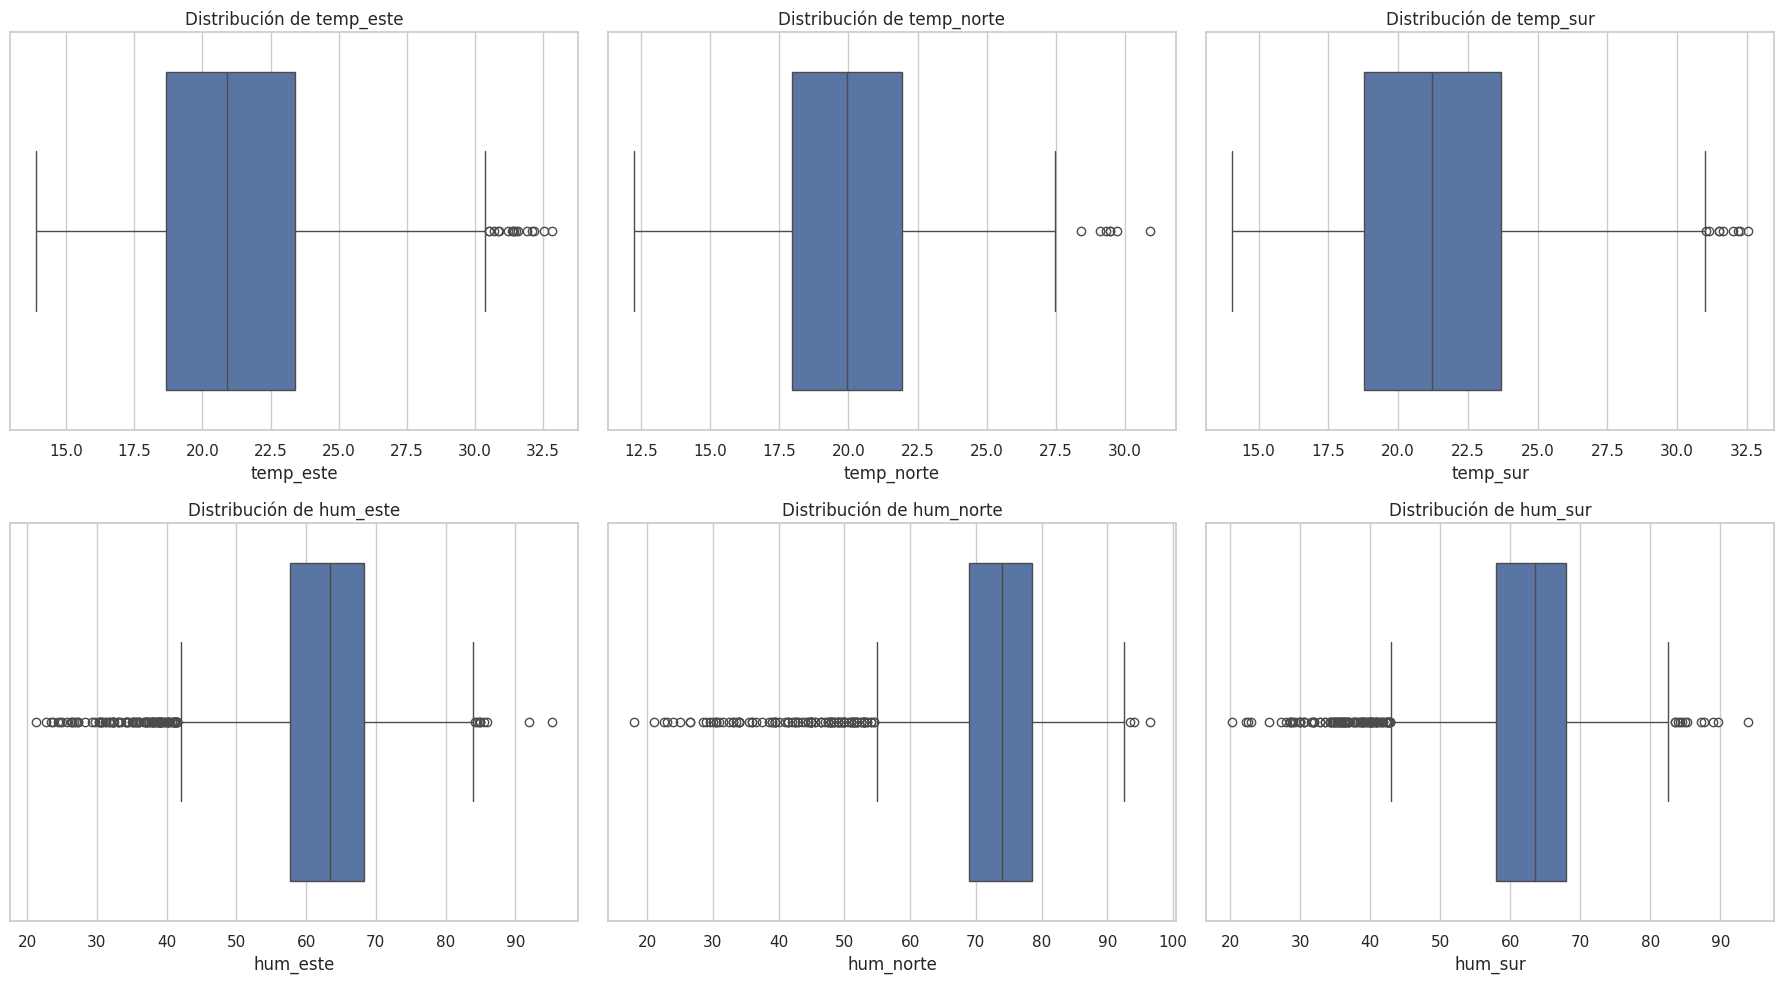

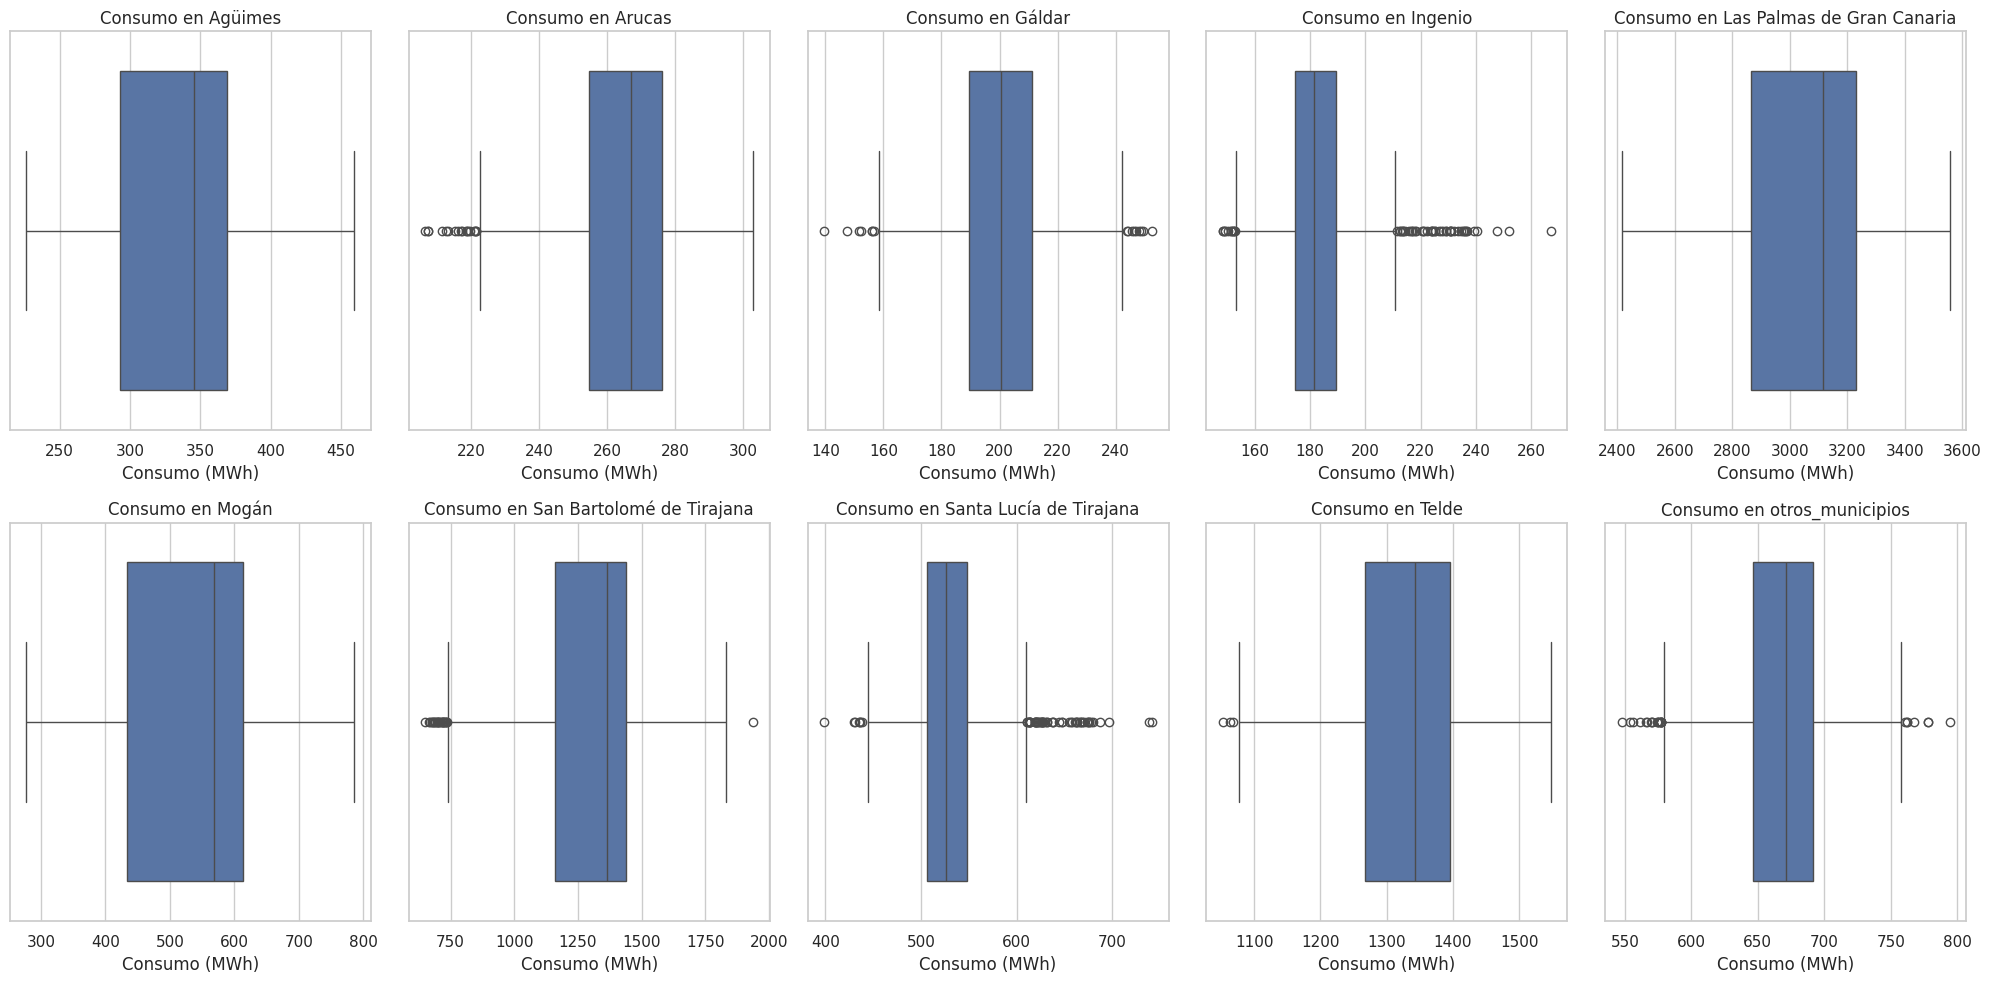

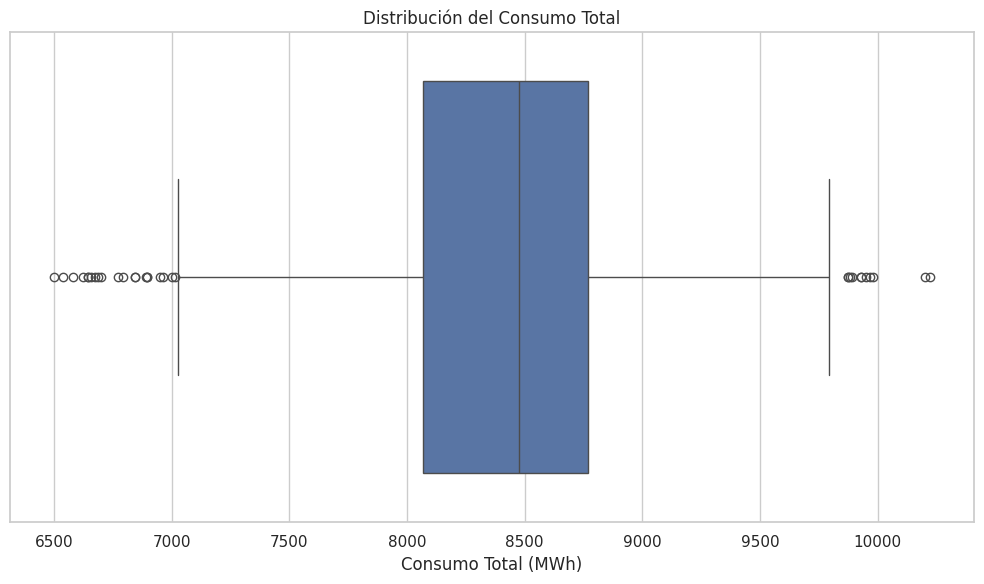

In [4]:
# Verificar la presencia de outliers en las variables meteorológicas
variables_meteorologicas = ['temp_este', 'temp_norte', 'temp_sur', 'hum_este', 'hum_norte', 'hum_sur']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, var in enumerate(variables_meteorologicas):
    sns.boxplot(x=df[var], ax=axes[i])
    axes[i].set_title(f'Distribución de {var}')
    axes[i].set_xlabel(var)

plt.tight_layout()
plt.show()

# Verificar la presencia de outliers en las variables de consumo
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

for i, municipio in enumerate(municipios):
    sns.boxplot(x=df[municipio], ax=axes[i])
    axes[i].set_title(f'Consumo en {municipio}')
    axes[i].set_xlabel('Consumo (MWh)')

plt.tight_layout()
plt.show()

# Boxplot para consumo total
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['consumo_total'])
plt.title('Distribución del Consumo Total')
plt.xlabel('Consumo Total (MWh)')
plt.tight_layout()
plt.show()

In [5]:
# Detección de outliers usando el método IQR (Rango Intercuartílico)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))
print("Número de outliers por columna:")
print(outliers.sum())

Número de outliers por columna:
fecha                           0
temp_este                      16
temp_norte                      7
temp_sur                        9
hum_este                      117
hum_norte                     120
hum_sur                       119
Agüimes                         0
Arucas                         18
Gáldar                         16
Ingenio                        56
Las Palmas de Gran Canaria      0
Mogán                           0
San Bartolomé de Tirajana      26
Santa Lucía de Tirajana        62
Telde                           3
otros_municipios               25
consumo_total                  32
dtype: int64


### **Visualización de datos**

La visualización de datos es muy útil para comprender patrones, tendencias y relaciones en el conjunto de datos.

En las siguientes celdas, realizamos diversas visualizaciones para explorar las características de los datos.

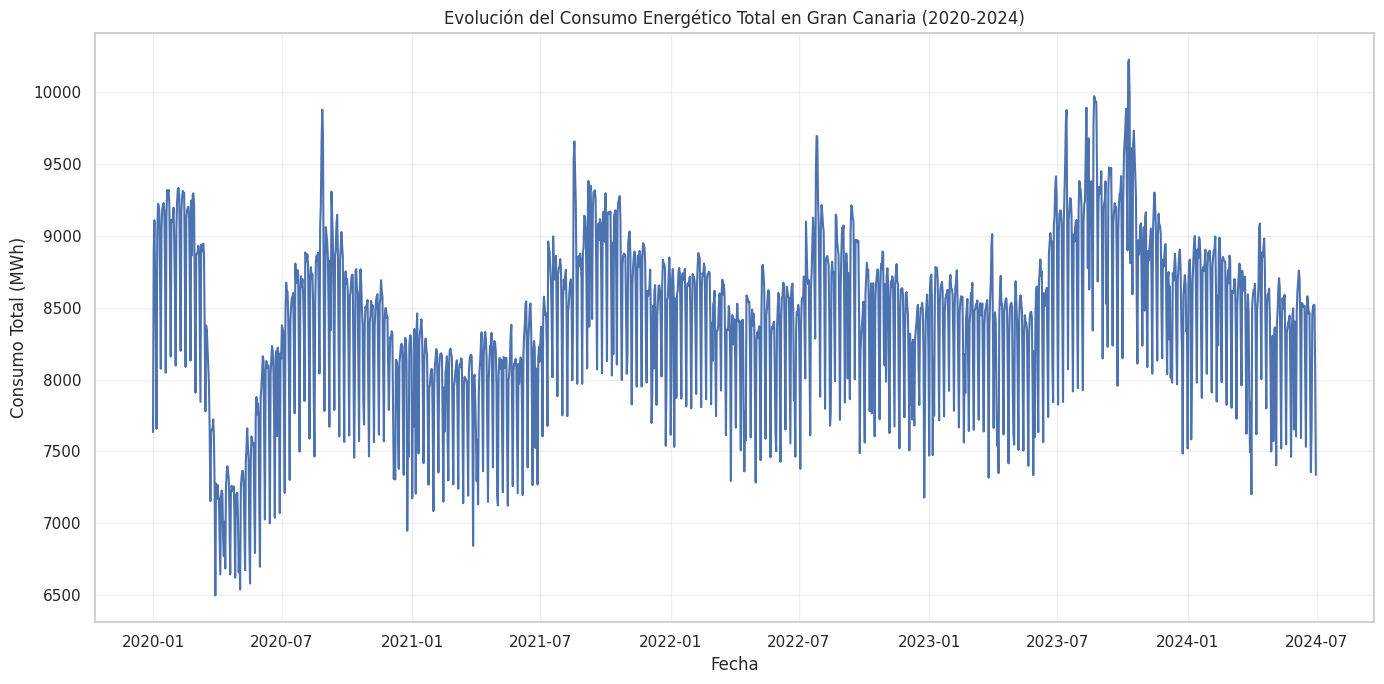

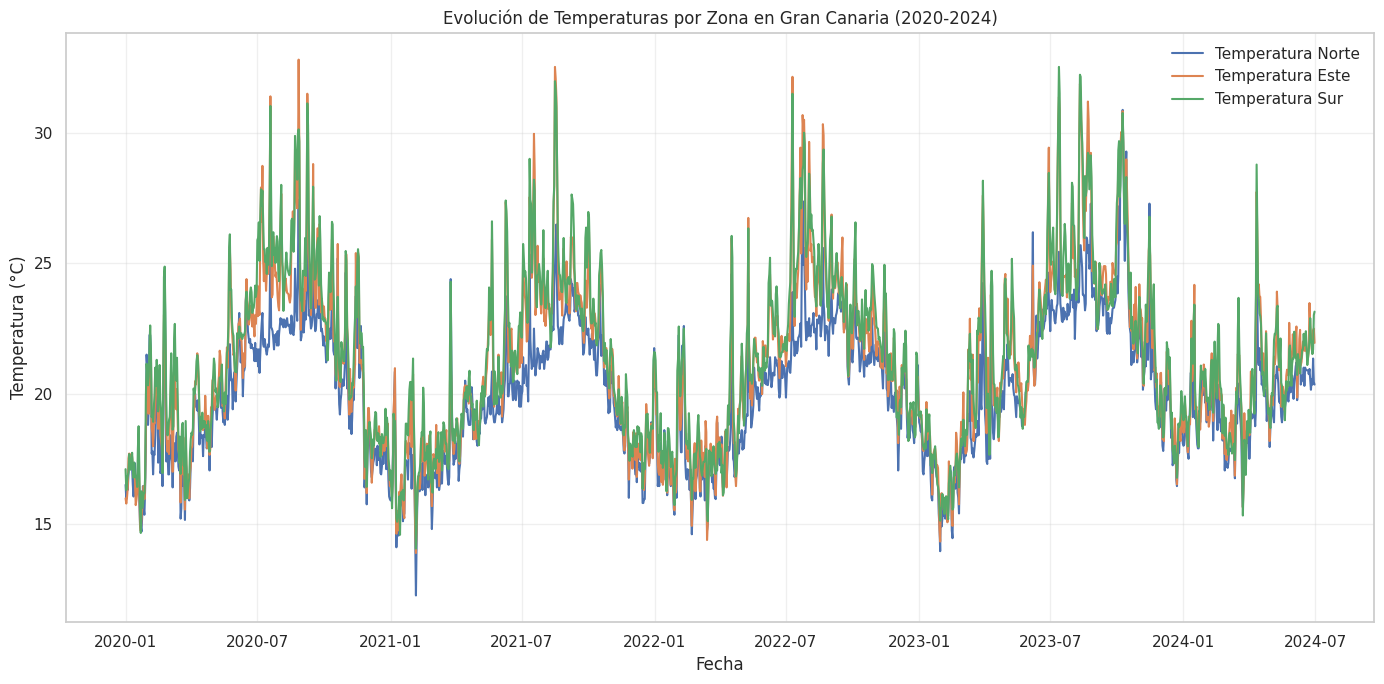

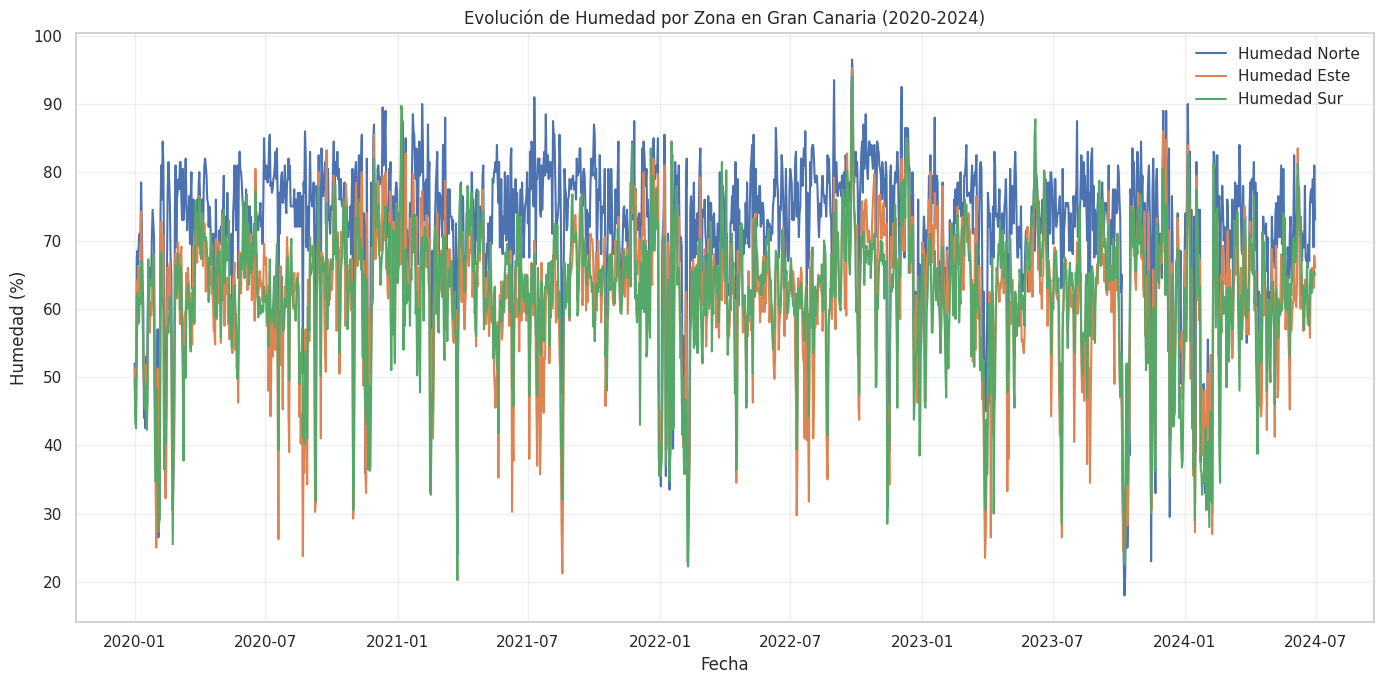

In [6]:
# Evolución temporal del consumo total
plt.figure(figsize=(14, 7))
plt.plot(df['fecha'], df['consumo_total'])
plt.title('Evolución del Consumo Energético Total en Gran Canaria (2020-2024)')
plt.xlabel('Fecha')
plt.ylabel('Consumo Total (MWh)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Evolución temporal de las temperaturas por zona
plt.figure(figsize=(14, 7))
plt.plot(df['fecha'], df['temp_norte'], label='Temperatura Norte')
plt.plot(df['fecha'], df['temp_este'], label='Temperatura Este')
plt.plot(df['fecha'], df['temp_sur'], label='Temperatura Sur')
plt.title('Evolución de Temperaturas por Zona en Gran Canaria (2020-2024)')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Evolución temporal de la humedad por zona
plt.figure(figsize=(14, 7))
plt.plot(df['fecha'], df['hum_norte'], label='Humedad Norte')
plt.plot(df['fecha'], df['hum_este'], label='Humedad Este')
plt.plot(df['fecha'], df['hum_sur'], label='Humedad Sur')
plt.title('Evolución de Humedad por Zona en Gran Canaria (2020-2024)')
plt.xlabel('Fecha')
plt.ylabel('Humedad (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

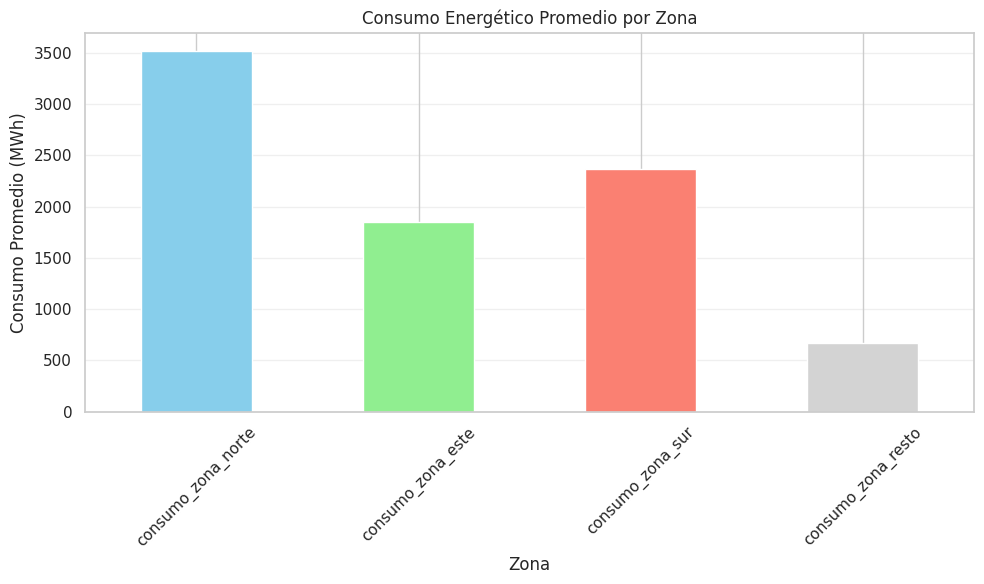

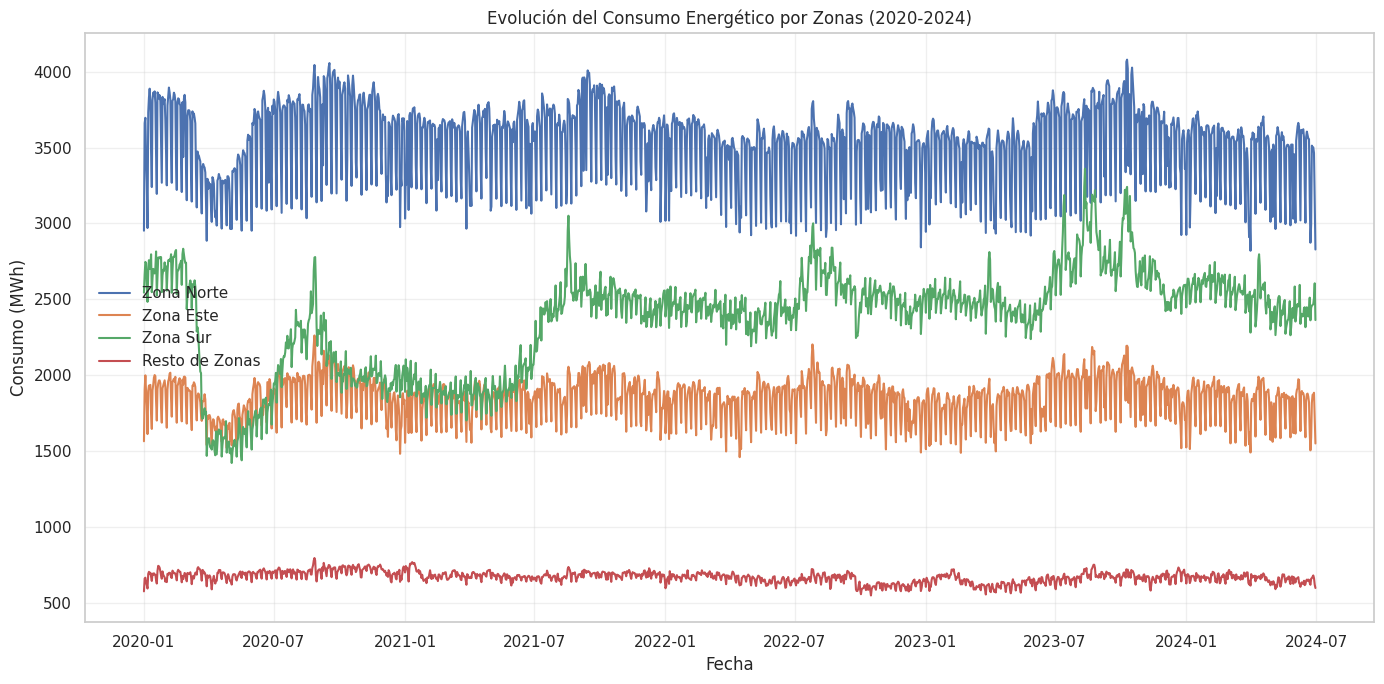

In [7]:
# Crear columnas para agrupar municipios por zonas
df['consumo_zona_norte'] = df[['Arucas', 'Gáldar', 'Las Palmas de Gran Canaria']].sum(axis=1)
df['consumo_zona_este'] = df[['Agüimes', 'Ingenio', 'Telde']].sum(axis=1)
df['consumo_zona_sur'] = df[['Mogán', 'San Bartolomé de Tirajana', 'Santa Lucía de Tirajana']].sum(axis=1)
df['consumo_zona_resto'] = df['otros_municipios']

# Visualizar la distribución del consumo por zonas
consumo_zonas = df[['consumo_zona_norte', 'consumo_zona_este', 'consumo_zona_sur', 'consumo_zona_resto']].mean()
plt.figure(figsize=(10, 6))
consumo_zonas.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon', 'lightgray'])
plt.title('Consumo Energético Promedio por Zona')
plt.xlabel('Zona')
plt.ylabel('Consumo Promedio (MWh)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Evolución temporal del consumo por zonas
plt.figure(figsize=(14, 7))
plt.plot(df['fecha'], df['consumo_zona_norte'], label='Zona Norte')
plt.plot(df['fecha'], df['consumo_zona_este'], label='Zona Este')
plt.plot(df['fecha'], df['consumo_zona_sur'], label='Zona Sur')
plt.plot(df['fecha'], df['consumo_zona_resto'], label='Resto de Zonas')
plt.title('Evolución del Consumo Energético por Zonas (2020-2024)')
plt.xlabel('Fecha')
plt.ylabel('Consumo (MWh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

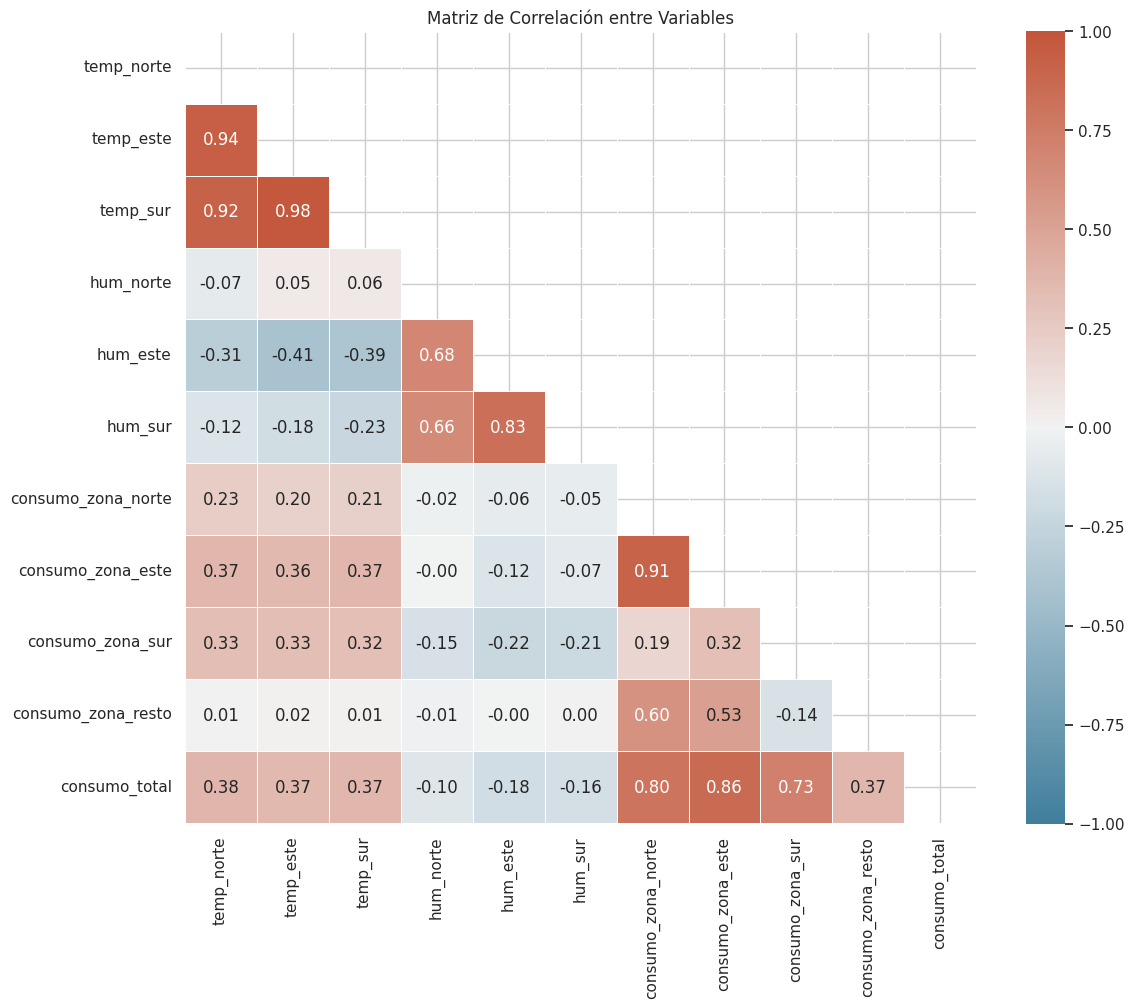

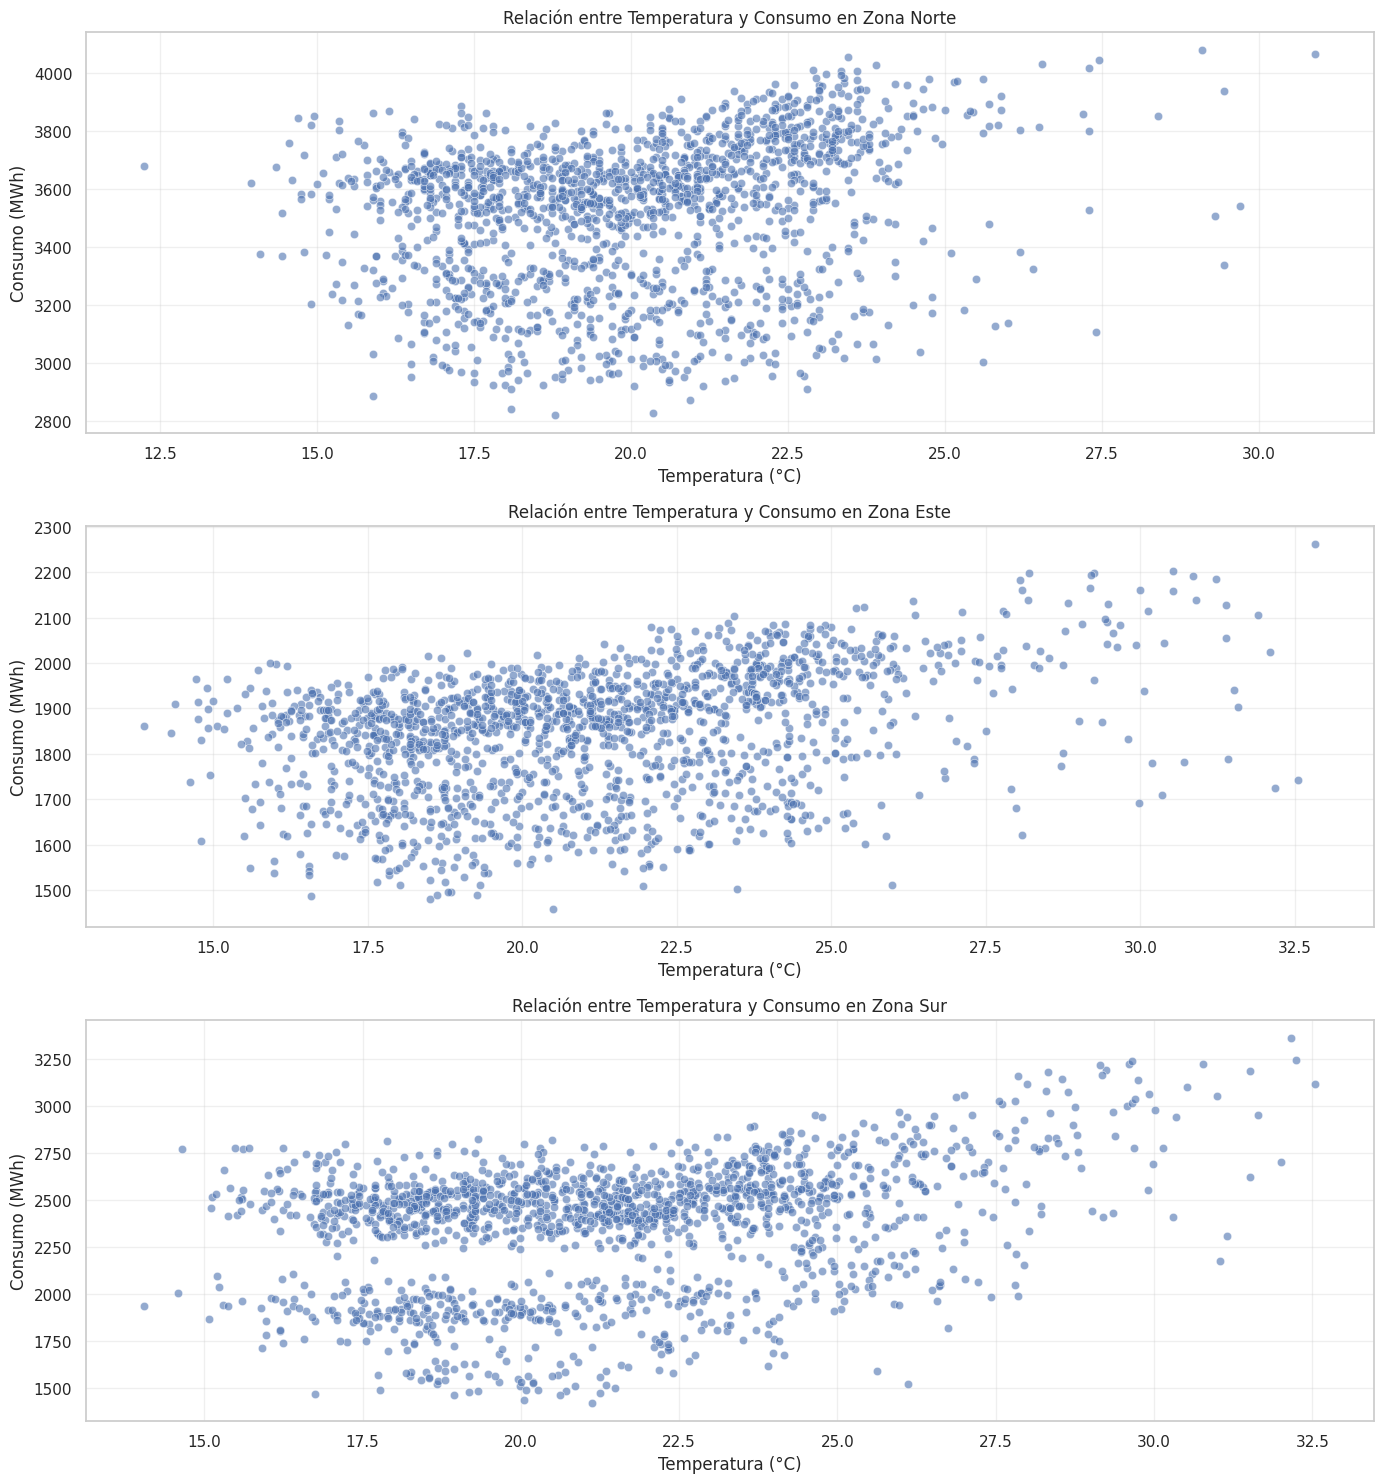

In [11]:
# Análisis de correlación entre variables
# Seleccionar variables relevantes para el análisis de correlación
variables_correlacion = ['temp_norte', 'temp_este', 'temp_sur',
                         'hum_norte', 'hum_este', 'hum_sur',
                         'consumo_zona_norte', 'consumo_zona_este', 'consumo_zona_sur', 'consumo_zona_resto',
                         'consumo_total']

# Calcular la matriz de correlación
corr_matrix = df[variables_correlacion].corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, fmt='.2f')
plt.title('Matriz de Correlación entre Variables')
plt.tight_layout()
plt.show()

# Visualizar la relación entre temperatura y consumo por zonas
fig, axes = plt.subplots(3, 1, figsize=(14, 15))

# Zona Norte
sns.scatterplot(x=df['temp_norte'], y=df['consumo_zona_norte'], ax=axes[0], alpha=0.6)
axes[0].set_title('Relación entre Temperatura y Consumo en Zona Norte')
axes[0].set_xlabel('Temperatura (°C)')
axes[0].set_ylabel('Consumo (MWh)')
axes[0].grid(True, alpha=0.3)

# Zona Este
sns.scatterplot(x=df['temp_este'], y=df['consumo_zona_este'], ax=axes[1], alpha=0.6)
axes[1].set_title('Relación entre Temperatura y Consumo en Zona Este')
axes[1].set_xlabel('Temperatura (°C)')
axes[1].set_ylabel('Consumo (MWh)')
axes[1].grid(True, alpha=0.3)

# Zona Sur
sns.scatterplot(x=df['temp_sur'], y=df['consumo_zona_sur'], ax=axes[2], alpha=0.6)
axes[2].set_title('Relación entre Temperatura y Consumo en Zona Sur')
axes[2].set_xlabel('Temperatura (°C)')
axes[2].set_ylabel('Consumo (MWh)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### **Optimización, normalización y calidad del dataset**

Una vez explorado el conjunto de datos, procedemos a optimizarlo y prepararlo para su uso en el entrenamiento del modelo predictivo. Este proceso incluye la normalización de variables, la creación de características adicionales y la división en conjuntos de entrenamiento, validación y prueba.

In [21]:
# Extraer características temporales
df['año'] = df['fecha'].dt.year
df['mes'] = df['fecha'].dt.month
df['dia_semana'] = df['fecha'].dt.dayofweek  # 0 es lunes, 6 es domingo
df['dia_año'] = df['fecha'].dt.dayofyear
df['es_fin_semana'] = df['dia_semana'].apply(lambda x: 1 if x >= 5 else 0)  # 1 si es sábado o domingo

# Crear variables cíclicas para capturar la estacionalidad
df['mes_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
df['mes_cos'] = np.cos(2 * np.pi * df['mes'] / 12)
df['dia_año_sin'] = np.sin(2 * np.pi * df['dia_año'] / 365)
df['dia_año_cos'] = np.cos(2 * np.pi * df['dia_año'] / 365)

# Mostrar las nuevas características
print("Primeras filas con las nuevas características temporales:")
df[['fecha', 'año', 'mes', 'dia_semana', 'dia_año', 'es_fin_semana', 'mes_sin', 'mes_cos', 'dia_año_sin', 'dia_año_cos']].head()

Primeras filas con las nuevas características temporales:


,fecha,año,mes,dia_semana,dia_año,es_fin_semana,mes_sin,mes_cos,dia_año_sin,dia_año_cos
0,2020-01-01,2020,1,2,1,0,0.5,0.866025,0.017213,0.999852
1,2020-01-02,2020,1,3,2,0,0.5,0.866025,0.034422,0.999407
2,2020-01-03,2020,1,4,3,0,0.5,0.866025,0.051620,0.998667
3,2020-01-04,2020,1,5,4,1,0.5,0.866025,0.068802,0.997630
4,2020-01-05,2020,1,6,5,1,0.5,0.866025,0.085965,0.996298


### **Preparación de variables para los modelos de Regresión Lineal y Random Forest**

Para evitar la fuga de datos, excluimos las variables de consumo por zonas para estos modelos.

In [13]:
# Seleccionar las variables para los modelos de regresión lineal y random forest
# Excluimos las variables de consumo por zonas para evitar fuga de datos
features_modelo = [
    # Variables meteorológicas
    'temp_norte', 'temp_este', 'temp_sur',
    'hum_norte', 'hum_este', 'hum_sur',
    # Variables temporales cíclicas
    'mes_sin', 'mes_cos', 'dia_año_sin', 'dia_año_cos', 'es_fin_semana'
]

# Crear los conjuntos de características para los modelos regresión lineal y random forest
X_modelo = df[features_modelo]

# Mostrar las dimensiones
print(f"Dimensiones de X para modelos de Regresión Lineal y Random Forest: {X_modelo.shape}")

Dimensiones de X para modelos de Regresión Lineal y Random Forest: (1643, 11)


### **Preparación de variables para el modelado de la Red Neuronal Multi-Branch (Multi-Branch Networks - MBNs)**

Para la red neuronal Multi-Branch, seguimos el enfoque original que incluye los consumos por zonas como características.

In [14]:
# Seleccionar las variables para el modelo de red neuronal Multi-Branch
features_nn = [
    # Variables meteorológicas
    'temp_norte', 'temp_este', 'temp_sur',
    'hum_norte', 'hum_este', 'hum_sur',
    # Variables temporales cíclicas
    'mes_sin', 'mes_cos', 'dia_año_sin', 'dia_año_cos', 'es_fin_semana',
    # Consumo por zonas
    'consumo_zona_norte', 'consumo_zona_este', 'consumo_zona_sur', 'consumo_zona_resto'
]

# Variable objetivo
target = 'consumo_total'

# Crear los conjuntos de características y objetivo para la red neuronal
X_nn = df[features_nn]
y = df[target]

# Mostrar las dimensiones
print(f"Dimensiones de X para red neuronal: {X_nn.shape}")
print(f"Dimensiones de y: {y.shape}")

Dimensiones de X para red neuronal: (1643, 15)
Dimensiones de y: (1643,)


### **Escalado de variables para los modelos de Regresión Lineal y Random Forest**

In [15]:
# Escalado de variables para los modelos de Regresión Lineal y Random Forest
scaler_modelo = StandardScaler()
X_modelo_scaled = scaler_modelo.fit_transform(X_modelo)
X_modelo_scaled = pd.DataFrame(X_modelo_scaled, columns=features_modelo)

# Mostrar las primeras filas de los datos escalados
X_modelo_scaled.head()

,temp_norte,temp_este,temp_sur,hum_norte,hum_este,hum_sur,mes_sin,mes_cos,dia_año_sin,dia_año_cos,es_fin_semana
0,-1.389372,-1.592624,-1.318990,-1.933567,-0.997886,-1.193017,0.619503,1.251784,-0.076069,1.413359,-0.632994
1,-1.605420,-1.654275,-1.563477,-2.463476,-1.660596,-1.836022,0.619503,1.251784,-0.051606,1.412731,-0.632994
2,-1.389372,-1.580294,-1.471794,-2.126261,-1.518587,-1.910215,0.619503,1.251784,-0.027158,1.411684,-0.632994
3,-1.467935,-1.469323,-1.404561,-0.440188,-0.122163,-0.846784,0.619503,1.251784,-0.002732,1.410218,1.579793
4,-1.232247,-1.117914,-1.355663,-0.343841,0.232860,0.043530,0.619503,1.251784,0.021666,1.408334,1.579793


### **Escalado de variables para la Red Neuronal Multi-Branch (Multi-Branch Networks - MBNs)**

In [16]:
# Escalado de variables meteorológicas y temporales
scaler_meteo_temp = StandardScaler()
meteo_temp_features = ['temp_norte', 'temp_este', 'temp_sur', 'hum_norte', 'hum_este', 'hum_sur',
                       'mes_sin', 'mes_cos', 'dia_año_sin', 'dia_año_cos', 'es_fin_semana']
X_meteo_temp = X_nn[meteo_temp_features]
X_meteo_temp_scaled = scaler_meteo_temp.fit_transform(X_meteo_temp)

# Escalado de variables de consumo por zonas
scaler_consumo = StandardScaler()
consumo_features = ['consumo_zona_norte', 'consumo_zona_este', 'consumo_zona_sur', 'consumo_zona_resto']
X_consumo = X_nn[consumo_features]
X_consumo_scaled = scaler_consumo.fit_transform(X_consumo)

# Escalado de la variable objetivo
scaler_target = StandardScaler()
y_scaled = scaler_target.fit_transform(y.values.reshape(-1, 1)).flatten()

# Combinar todas las variables escaladas para la red neuronal
X_nn_scaled = np.hstack((X_meteo_temp_scaled, X_consumo_scaled))
X_nn_scaled = pd.DataFrame(X_nn_scaled, columns=meteo_temp_features + consumo_features)

# Mostrar las primeras filas de los datos escalados
X_nn_scaled.head()

,temp_norte,temp_este,temp_sur,hum_norte,hum_este,hum_sur,mes_sin,mes_cos,dia_año_sin,dia_año_cos,es_fin_semana,consumo_zona_norte,consumo_zona_este,consumo_zona_sur,consumo_zona_resto
0,-1.389372,-1.592624,-1.318990,-1.933567,-0.997886,-1.193017,0.619503,1.251784,-0.076069,1.413359,-0.632994,-2.220327,-2.074322,0.530857,-2.560477
1,-1.605420,-1.654275,-1.563477,-2.463476,-1.660596,-1.836022,0.619503,1.251784,-0.051606,1.412731,-0.632994,0.549299,0.434499,0.890514,-0.238078
2,-1.389372,-1.580294,-1.471794,-2.126261,-1.518587,-1.910215,0.619503,1.251784,-0.027158,1.411684,-0.632994,0.686909,1.112222,1.138727,-0.099840
3,-1.467935,-1.469323,-1.404561,-0.440188,-0.122163,-0.846784,0.619503,1.251784,-0.002732,1.410218,1.579793,-0.345518,0.282965,1.115232,-0.952536
4,-1.232247,-1.117914,-1.355663,-0.343841,0.232860,0.043530,0.619503,1.251784,0.021666,1.408334,1.579793,-0.964685,-0.362778,0.665736,-1.425282


### **División de datos para los modelos de Regresión Lineal y Random Forest**

In [23]:
# Dividir los datos en conjuntos de entrenamiento, validación y prueba para los modelos de Regresión Lineal y Random Forest
# Primero, separar los datos en entrenamiento (80%) y prueba (20%)
X_mod_train_val, X_mod_test, y_train_val_mod, y_test_mod = train_test_split(
    X_modelo_scaled, y_scaled, test_size=0.2, random_state=42, shuffle=False
)

# Luego, dividir los datos de entrenamiento en entrenamiento (75%) y validación (25%)
# Esto resulta en una división aproximada de 60% entrenamiento, 20% validación, 20% prueba
X_mod_train, X_mod_val, y_train_mod, y_val_mod = train_test_split(
    X_mod_train_val, y_train_val_mod, test_size=0.25, random_state=42, shuffle=False
)

# Verificar las dimensiones de los conjuntos
print(f"Dimensiones del conjunto de entrenamiento para modelos de Regresión Lineal y Random Forest: {X_mod_train.shape}")
print(f"Dimensiones del conjunto de validación para modelos de Regresión Lineal y Random Forest: {X_mod_val.shape}")
print(f"Dimensiones del conjunto de prueba para modelos de Regresión Lineal y Random Forest: {X_mod_test.shape}")

Dimensiones del conjunto de entrenamiento para modelos de Regresión Lineal y Random Forest: (985, 11)
Dimensiones del conjunto de validación para modelos de Regresión Lineal y Random Forest: (329, 11)
Dimensiones del conjunto de prueba para modelos de Regresión Lineal y Random Forest: (329, 11)


### **División de datos para la Red Neuronal Multi-Branch (Multi-Branch Networks - MBNs)**

In [26]:
# Dividir los datos en conjuntos de entrenamiento, validación y prueba para la red neuronal
# Usamos la misma semilla y proporciones para mantener la coherencia
X_nn_train_val, X_nn_test, y_train_val, y_test = train_test_split(
    X_nn_scaled, y_scaled, test_size=0.2, random_state=42, shuffle=False
)

X_nn_train, X_nn_val, y_train, y_val = train_test_split(
    X_nn_train_val, y_train_val, test_size=0.25, random_state=42, shuffle=False
)

# Verificar las dimensiones de los conjuntos
print(f"Dimensiones del conjunto de entrenamiento para red neuronal: {X_nn_train.shape}")
print(f"Dimensiones del conjunto de validación para red neuronal: {X_nn_val.shape}")
print(f"Dimensiones del conjunto de prueba para red neuronal: {X_nn_test.shape}")

Dimensiones del conjunto de entrenamiento para red neuronal: (985, 15)
Dimensiones del conjunto de validación para red neuronal: (329, 15)
Dimensiones del conjunto de prueba para red neuronal: (329, 15)


### **Implementación de modelos**

En las siguientes celdas se implementan tres modelos diferentes para la predicción del consumo energético:
1. Regresión Lineal (con búsqueda de hiperparámetros)
2. Random Forest (con búsqueda de hiperparámetros)
3. Red Neuronal Multi-Branch (Multi-Branch Networks - MBNs)

### **Modelo 1: Regresión Lineal con búsqueda de Hiperparámetros**

Se implementa varios modelos de regresión lineal (estándar, Ridge, Lasso y ElasticNet) y optimizamos sus hiperparámetros. Usamos solo las variables meteorológicas y temporales para evitar la fuga de datos.

In [54]:
# Definir los modelos de regresión lineal a evaluar
linear_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet Regression': ElasticNet()
}

# Definir los parámetros para la búsqueda de hiperparámetros
param_grids = {
    'Linear Regression': {},
    'Ridge Regression': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
    'Lasso Regression': {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]},
    'ElasticNet Regression': {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    }
}

# Realizar la búsqueda de hiperparámetros para cada modelo
best_linear_models = {}
best_scores = {}

for name, model in linear_models.items():
    print(f"\nOptimizando hiperparámetros para {name}...")

    if param_grids[name]:  # Si hay parámetros para optimizar
        grid_search = GridSearchCV(
            model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1
        )
        grid_search.fit(X_mod_train, y_train_mod)

        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_score = -grid_search.best_score_  # Convertir a MSE positivo

        print(f"Mejores parámetros: {best_params}")
        print(f"Mejor MSE en validación cruzada: {best_score:.4f}")
    else:  # Para LinearRegression que no tiene hiperparámetros
        model.fit(X_mod_train, y_train_mod)
        best_model = model
        best_score = mean_squared_error(y_val_mod, model.predict(X_mod_val))
        print(f"MSE en validación: {best_score:.4f}")

    best_linear_models[name] = best_model
    best_scores[name] = best_score

# Identificar el mejor modelo de regresión lineal
best_linear_model_name = min(best_scores, key=best_scores.get)
best_linear_model = best_linear_models[best_linear_model_name]

print(f"\nEl mejor modelo de regresión lineal es: {best_linear_model_name}")
print(f"MSE: {best_scores[best_linear_model_name]:.4f}")


Optimizando hiperparámetros para Linear Regression...
MSE en validación: 0.4955

Optimizando hiperparámetros para Ridge Regression...
Mejores parámetros: {'alpha': 100.0}
Mejor MSE en validación cruzada: 0.7642

Optimizando hiperparámetros para Lasso Regression...
Mejores parámetros: {'alpha': 0.1}
Mejor MSE en validación cruzada: 0.7635

Optimizando hiperparámetros para ElasticNet Regression...
Mejores parámetros: {'alpha': 0.1, 'l1_ratio': 0.7}
Mejor MSE en validación cruzada: 0.7633

El mejor modelo de regresión lineal es: Linear Regression
MSE: 0.4955


In [55]:
# Deshacer el escalado para obtener predicciones en la escala original
y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluar el mejor modelo de regresión lineal en el conjunto de prueba
y_pred_linear = best_linear_model.predict(X_mod_test)

# Deshacer el escalado para obtener predicciones en la escala original
y_pred_linear_original = scaler_target.inverse_transform(y_pred_linear.reshape(-1, 1)).flatten()

# Calcular métricas
mae_linear = mean_absolute_error(y_test_original, y_pred_linear_original)
rmse_linear = np.sqrt(mean_squared_error(y_test_original, y_pred_linear_original))
r2_linear = r2_score(y_test_original, y_pred_linear_original)

print(f"Métricas en el conjunto de prueba - {best_linear_model_name}:")
print(f"MAE: {mae_linear:.2f} MWh")
print(f"RMSE: {rmse_linear:.2f} MWh")
print(f"R²: {r2_linear:.4f}")

Métricas en el conjunto de prueba - Linear Regression:
MAE: 372.80 MWh
RMSE: 448.23 MWh
R²: 0.3174


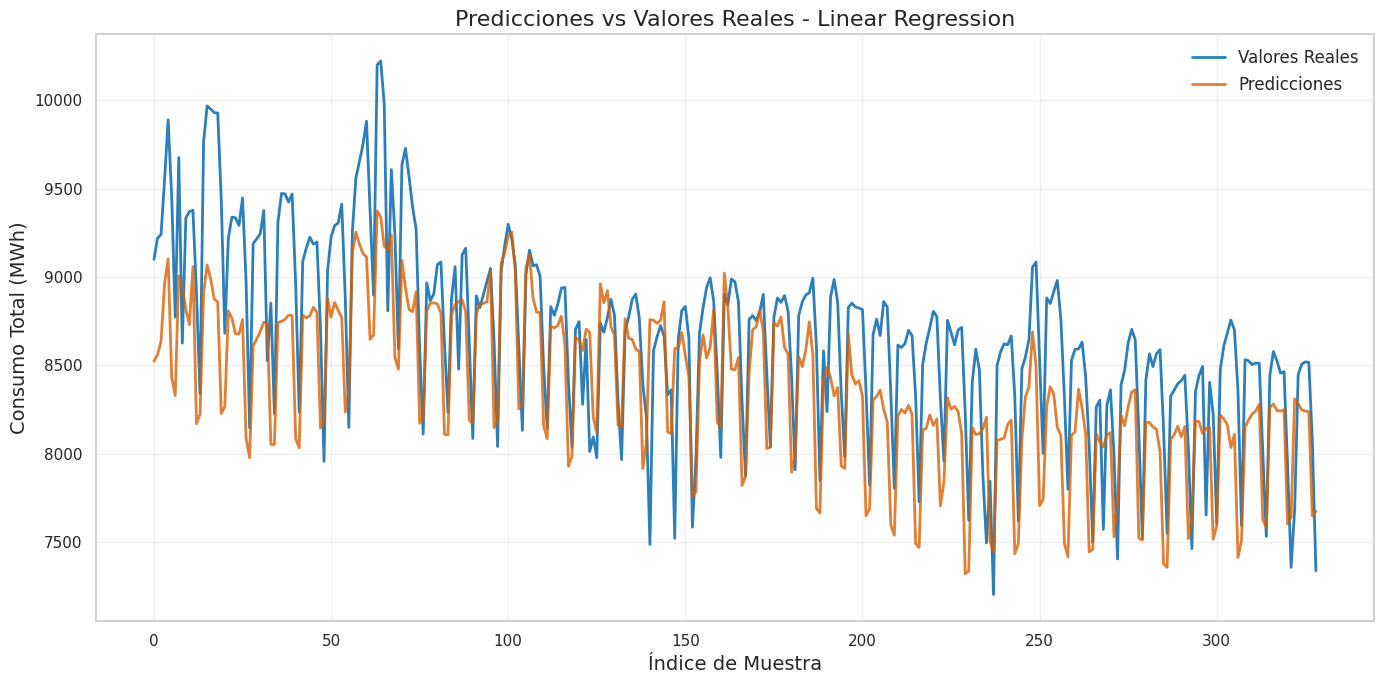

In [56]:
# Visualizar predicciones vs valores reales
plt.figure(figsize=(14, 7))
plt.plot(y_test_original, label='Valores Reales', color='#2C7FB8', linewidth=2)
plt.plot(y_pred_linear_original, label='Predicciones', color='#D95F02', linewidth=2, alpha=0.8)
plt.title(f'Predicciones vs Valores Reales - {best_linear_model_name}', fontsize=16)
plt.xlabel('Índice de Muestra', fontsize=14)
plt.ylabel('Consumo Total (MWh)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### **Modelo 2: Random Forest con búsqueda de Hiperparámetros**

Se implementa un modelo de Random Forest y optimizamos sus hiperparámetros. Al igual que con la regresión lineal, usamos solo las variables meteorológicas y temporales para evitar la fuga de datos.

In [57]:
# Definir el espacio de búsqueda para Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt']
}

# Usar RandomizedSearchCV para optimizar hiperparámetros (más eficiente que GridSearchCV para espacios grandes)
rf_model = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_grid_rf, n_iter=20, cv=5,
    scoring='neg_mean_squared_error', n_jobs=-1, random_state=42
)

print("Optimizando hiperparámetros para Random Forest...")
random_search.fit(X_mod_train, y_train_mod)

# Obtener el mejor modelo
best_rf_model = random_search.best_estimator_
best_rf_params = random_search.best_params_
best_rf_score = -random_search.best_score_  # Convertir a MSE positivo

print(f"Mejores parámetros: {best_rf_params}")
print(f"Mejor MSE en validación cruzada: {best_rf_score:.4f}")

Optimizando hiperparámetros para Random Forest...
Mejores parámetros: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None}
Mejor MSE en validación cruzada: 0.8177


In [58]:
# Evaluar el modelo de Random Forest en el conjunto de prueba
y_pred_rf = best_rf_model.predict(X_mod_test)

# Deshacer el escalado para obtener predicciones en la escala original
y_pred_rf_original = scaler_target.inverse_transform(y_pred_rf.reshape(-1, 1)).flatten()

# Calcular métricas
mae_rf = mean_absolute_error(y_test_original, y_pred_rf_original)
rmse_rf = np.sqrt(mean_squared_error(y_test_original, y_pred_rf_original))
r2_rf = r2_score(y_test_original, y_pred_rf_original)

print("Métricas en el conjunto de prueba - Random Forest:")
print(f"MAE: {mae_rf:.2f} MWh")
print(f"RMSE: {rmse_rf:.2f} MWh")
print(f"R²: {r2_rf:.4f}")

Métricas en el conjunto de prueba - Random Forest:
MAE: 383.13 MWh
RMSE: 450.79 MWh
R²: 0.3096


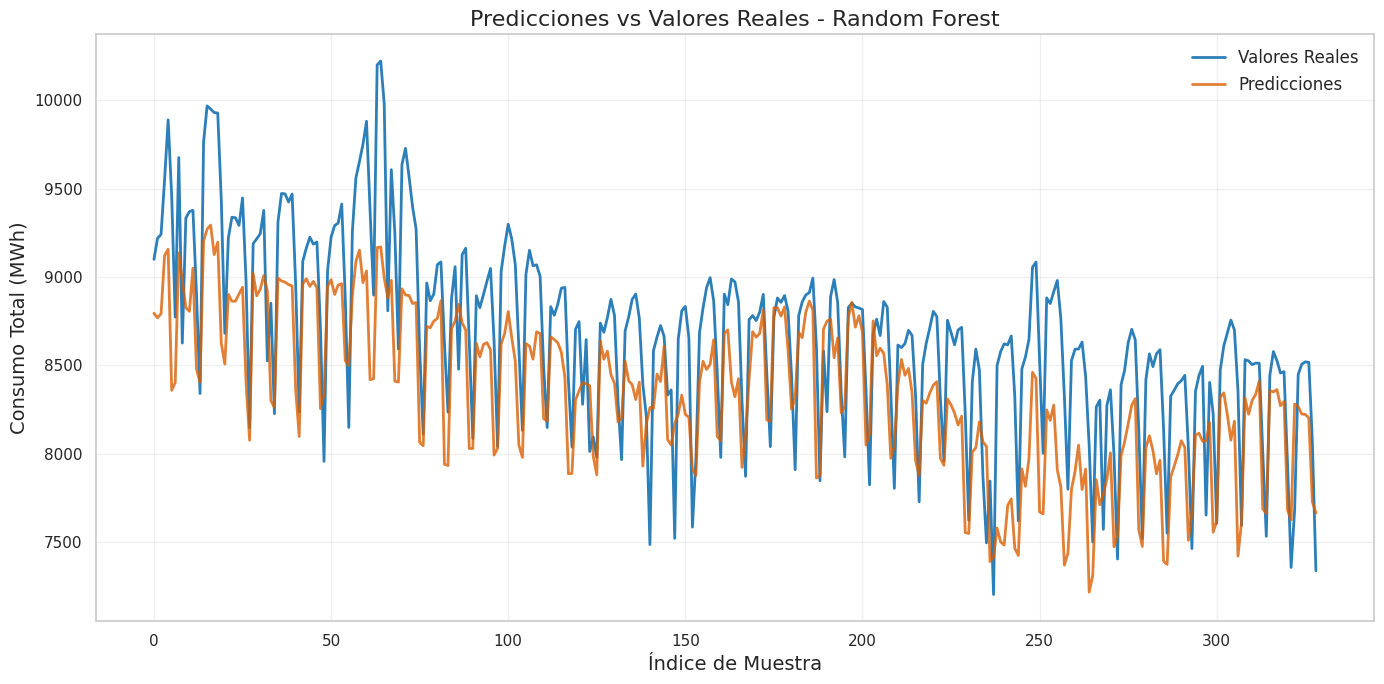

In [59]:
# Visualizar predicciones vs valores reales
plt.figure(figsize=(14, 7))
plt.plot(y_test_original, label='Valores Reales', color='#2C7FB8', linewidth=2)
plt.plot(y_pred_rf_original, label='Predicciones', color='#D95F02', linewidth=2, alpha=0.8)
plt.title('Predicciones vs Valores Reales - Random Forest', fontsize=16)
plt.xlabel('Índice de Muestra', fontsize=14)
plt.ylabel('Consumo Total (MWh)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### **Modelo 3: Red Neuronal Multi-Branch (Multi-Branch Networks - MBNs)**

Se implementa el modelo de Red Neuronal Multi-Branch (Multi-Branch Networks - MBNs).

In [60]:
# Definir una clase de conjunto de datos personalizada para PyTorch
class EnergyDataset(Dataset):
    def __init__(self, X, y):
        # Convertir los datos a tensores de PyTorch
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Definir la arquitectura del modelo de red neuronal Multi-Branch
class MultiBranchNeuralNetwork(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(MultiBranchNeuralNetwork, self).__init__()

        # Subred para la zona norte (temperatura y humedad)
        self.norte_subnet = nn.Sequential(
            nn.Linear(2, 16),  # 2 entradas: temperatura y humedad
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(16, 8),
            nn.ReLU()
        )

        # Subred para la zona este (temperatura y humedad)
        self.este_subnet = nn.Sequential(
            nn.Linear(2, 16),  # 2 entradas: temperatura y humedad
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(16, 8),
            nn.ReLU()
        )

        # Subred para la zona sur (temperatura y humedad)
        self.sur_subnet = nn.Sequential(
            nn.Linear(2, 16),  # 2 entradas: temperatura y humedad
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(16, 8),
            nn.ReLU()
        )

        # Subred para variables temporales
        self.temporal_subnet = nn.Sequential(
            nn.Linear(5, 16),  # 5 entradas: mes_sin, mes_cos, dia_año_sin, dia_año_cos, es_fin_semana
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(16, 8),
            nn.ReLU()
        )

        # Subred para consumo por zonas
        self.consumo_subnet = nn.Sequential(
            nn.Linear(4, 16),  # 4 entradas: consumo de las 4 zonas
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(16, 8),
            nn.ReLU()
        )

        # Red de integración
        self.integration_net = nn.Sequential(
            nn.Linear(40, 32),  # 40 entradas: 8*3 (zonas) + 8 (temporal) + 8 (consumo)
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(16, 1)  # 1 salida: consumo total
        )

    def forward(self, x):
        # Extraer las características para cada subred
        # Índices basados en el orden de las columnas en X_scaled
        temp_hum_norte = x[:, [0, 3]]  # temp_norte, hum_norte
        temp_hum_este = x[:, [1, 4]]   # temp_este, hum_este
        temp_hum_sur = x[:, [2, 5]]    # temp_sur, hum_sur
        temporal = x[:, 6:11]          # mes_sin, mes_cos, dia_año_sin, dia_año_cos, es_fin_semana
        consumo_zonas = x[:, 11:15]    # consumo_zona_norte, consumo_zona_este, consumo_zona_sur, consumo_zona_resto

        # Procesar cada conjunto de características a través de su subred correspondiente
        norte_out = self.norte_subnet(temp_hum_norte)
        este_out = self.este_subnet(temp_hum_este)
        sur_out = self.sur_subnet(temp_hum_sur)
        temporal_out = self.temporal_subnet(temporal)
        consumo_out = self.consumo_subnet(consumo_zonas)

        # Concatenar las salidas de todas las subredes
        combined = torch.cat([norte_out, este_out, sur_out, temporal_out, consumo_out], dim=1)

        # Procesar a través de la red de integración
        output = self.integration_net(combined)

        return output.squeeze()

In [61]:
# Crear los conjuntos de datos para PyTorch
train_dataset = EnergyDataset(X_nn_train, y_train)
val_dataset = EnergyDataset(X_nn_val, y_val)
test_dataset = EnergyDataset(X_nn_test, y_test)

# Crear los dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Inicializar el modelo
model_MultiBranch = MultiBranchNeuralNetwork(dropout_rate=0.2)
print(model_MultiBranch)

# Contar el número de parámetros entrenables
total_params = sum(p.numel() for p in model_MultiBranch.parameters() if p.requires_grad)
print(f"Número total de parámetros entrenables: {total_params}")

MultiBranchNeuralNetwork(
  (norte_subnet): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
  )
  (este_subnet): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
  )
  (sur_subnet): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
  )
  (temporal_subnet): Sequential(
    (0): Linear(in_features=5, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
  )
  (consumo_subnet): Sequential(
    (0): Linear(in_features=4, out_features=16, bi

In [62]:
# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model_MultiBranch.parameters(), lr=0.001, weight_decay=1e-5)

# Definir el planificador de tasa de aprendizaje
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# Función para entrenar el modelo
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100, early_stopping_patience=20):
    # Historiales para seguimiento
    train_losses = []
    val_losses = []

    # Para early stopping
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    best_model_state = None

    for epoch in range(num_epochs):
        # Modo de entrenamiento
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            # Poner a cero los gradientes
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass y optimización
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        # Calcular pérdida de entrenamiento promedio
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Modo de evaluación
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                val_loss = criterion(outputs, targets)
                running_val_loss += val_loss.item() * inputs.size(0)

        # Calcular pérdida de validación promedio
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        # Actualizar el planificador de tasa de aprendizaje
        scheduler.step(epoch_val_loss)

        # Imprimir progreso
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

        # Early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_without_improvement = 0
            best_model_state = model.state_dict().copy()
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= early_stopping_patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                # Restaurar el mejor modelo
                model.load_state_dict(best_model_state)
                break

    # Restaurar el mejor modelo si no se activó early stopping
    if epochs_without_improvement < early_stopping_patience:
        model.load_state_dict(best_model_state)

    return train_losses, val_losses

# Entrenar el modelo
train_losses_MultiBranch, val_losses_MultiBranch = train_model(
    model_MultiBranch, train_loader, val_loader, criterion, optimizer, scheduler,
    num_epochs=200, early_stopping_patience=30
)

Epoch 1/200, Train Loss: 1.0913, Val Loss: 0.6096
Epoch 10/200, Train Loss: 0.1499, Val Loss: 0.0324
Epoch 20/200, Train Loss: 0.1197, Val Loss: 0.0126
Epoch 30/200, Train Loss: 0.1070, Val Loss: 0.0126
Epoch 40/200, Train Loss: 0.0920, Val Loss: 0.0088
Epoch 50/200, Train Loss: 0.0928, Val Loss: 0.0103
Epoch 60/200, Train Loss: 0.0890, Val Loss: 0.0063
Epoch 70/200, Train Loss: 0.0800, Val Loss: 0.0114
Epoch 80/200, Train Loss: 0.0817, Val Loss: 0.0106
Epoch 90/200, Train Loss: 0.0836, Val Loss: 0.0101
Early stopping triggered after 91 epochs


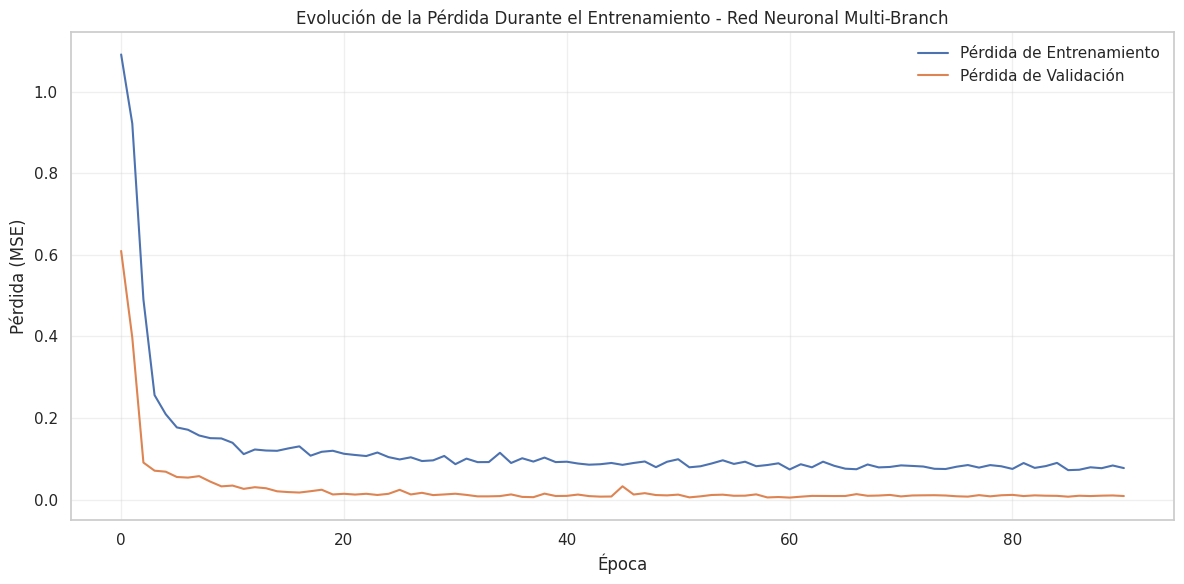

In [63]:
# Visualizar las curvas de pérdida
plt.figure(figsize=(12, 6))
plt.plot(train_losses_MultiBranch, label='Pérdida de Entrenamiento')
plt.plot(val_losses_MultiBranch, label='Pérdida de Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.title('Evolución de la Pérdida Durante el Entrenamiento - Red Neuronal Multi-Branch')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [64]:
# Evaluar el modelo en el conjunto de prueba
model_MultiBranch.eval()
y_pred_MultiBranch = []

with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model_MultiBranch(inputs)
        y_pred_MultiBranch.extend(outputs.numpy())

y_pred_MultiBranch = np.array(y_pred_MultiBranch)

# Deshacer el escalado para obtener predicciones en la escala original
y_pred_MultiBranch_original = scaler_target.inverse_transform(y_pred_MultiBranch.reshape(-1, 1)).flatten()
y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Calcular métricas
mae_MultiBranch = mean_absolute_error(y_test_original, y_pred_MultiBranch_original)
rmse_MultiBranch = np.sqrt(mean_squared_error(y_test_original, y_pred_MultiBranch_original))
r2_MultiBranch = r2_score(y_test_original, y_pred_MultiBranch_original)

print("Métricas en el conjunto de prueba - Red Neuronal Multi-Branch:")
print(f"MAE: {mae_MultiBranch:.2f} MWh")
print(f"RMSE: {rmse_MultiBranch:.2f} MWh")
print(f"R²: {r2_MultiBranch:.4f}")

Métricas en el conjunto de prueba - Red Neuronal Multi-Branch:
MAE: 46.04 MWh
RMSE: 76.30 MWh
R²: 0.9802


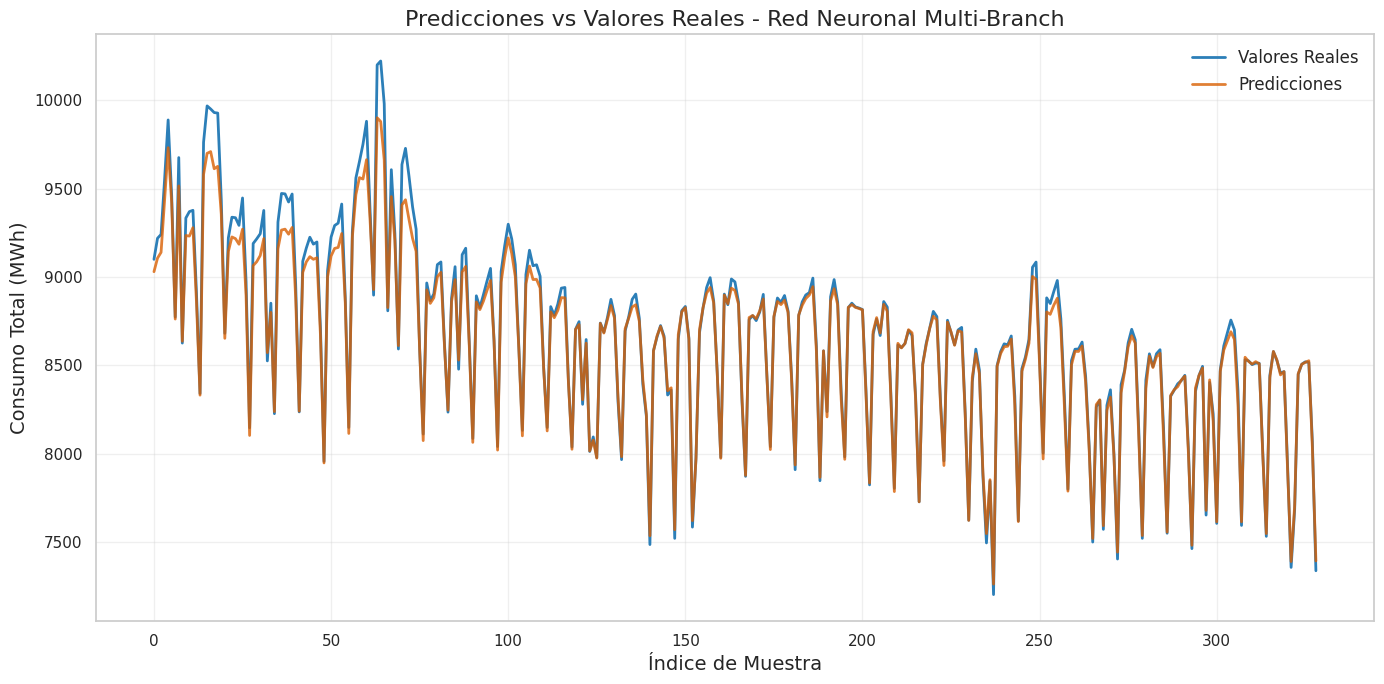

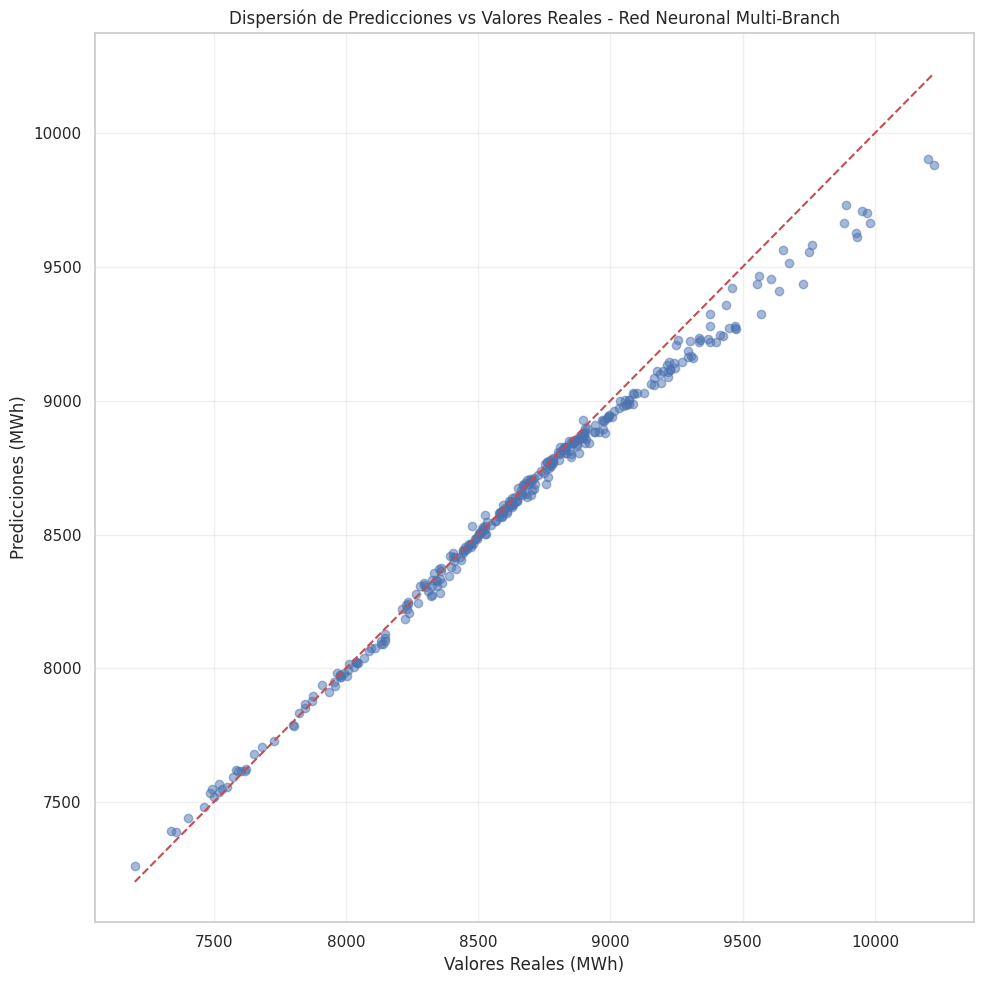

In [65]:
# Visualizar predicciones vs valores reales
plt.figure(figsize=(14, 7))
plt.plot(y_test_original, label='Valores Reales', color='#2C7FB8', linewidth=2)
plt.plot(y_pred_MultiBranch_original, label='Predicciones', color='#D95F02', linewidth=2, alpha=0.8)
plt.title('Predicciones vs Valores Reales - Red Neuronal Multi-Branch', fontsize=16)
plt.xlabel('Índice de Muestra', fontsize=14)
plt.ylabel('Consumo Total (MWh)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Gráfico de dispersión de predicciones vs valores reales
plt.figure(figsize=(10, 10))
plt.scatter(y_test_original, y_pred_MultiBranch_original, alpha=0.5)
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], 'r--')
plt.title('Dispersión de Predicciones vs Valores Reales - Red Neuronal Multi-Branch')
plt.xlabel('Valores Reales (MWh)')
plt.ylabel('Predicciones (MWh)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### **Análisis de rendimiento por zonas - Red Neuronal Multi-Branch (Multi-Branch Networks - MBNs)**

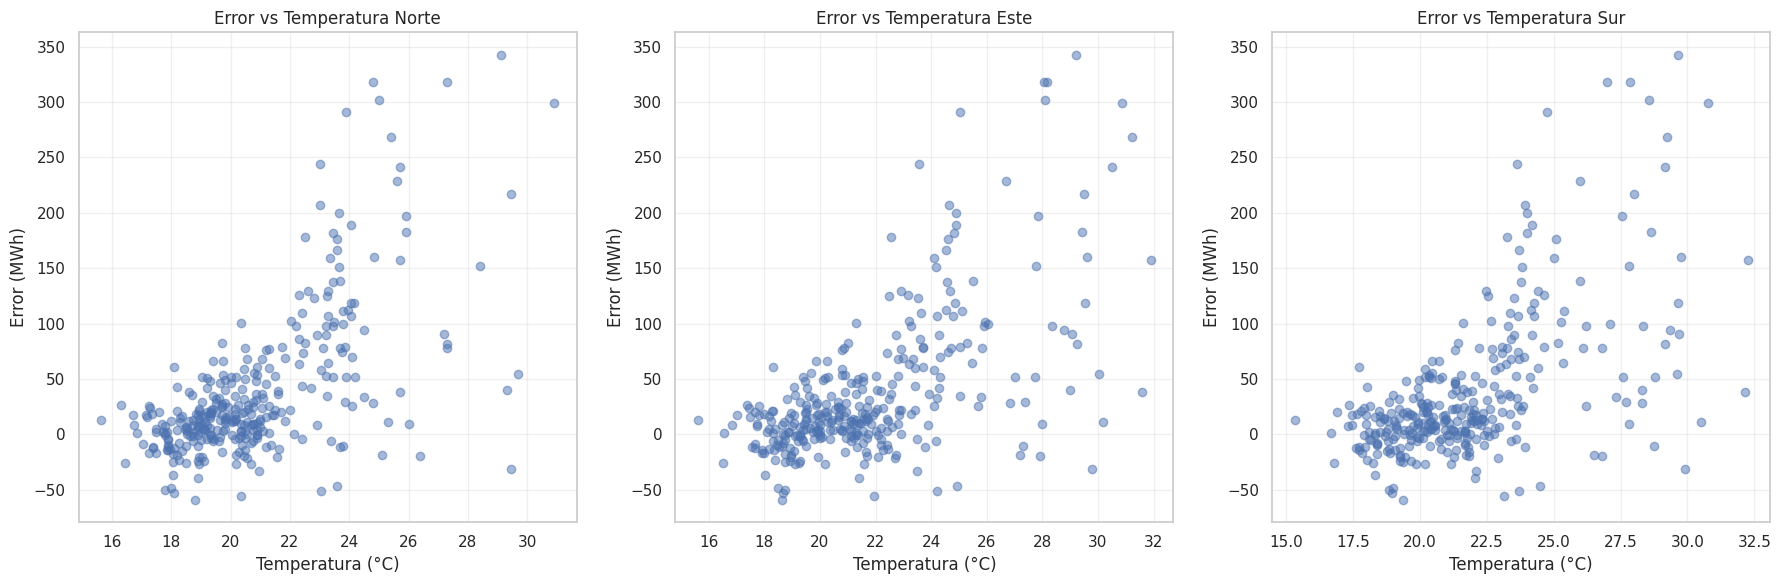

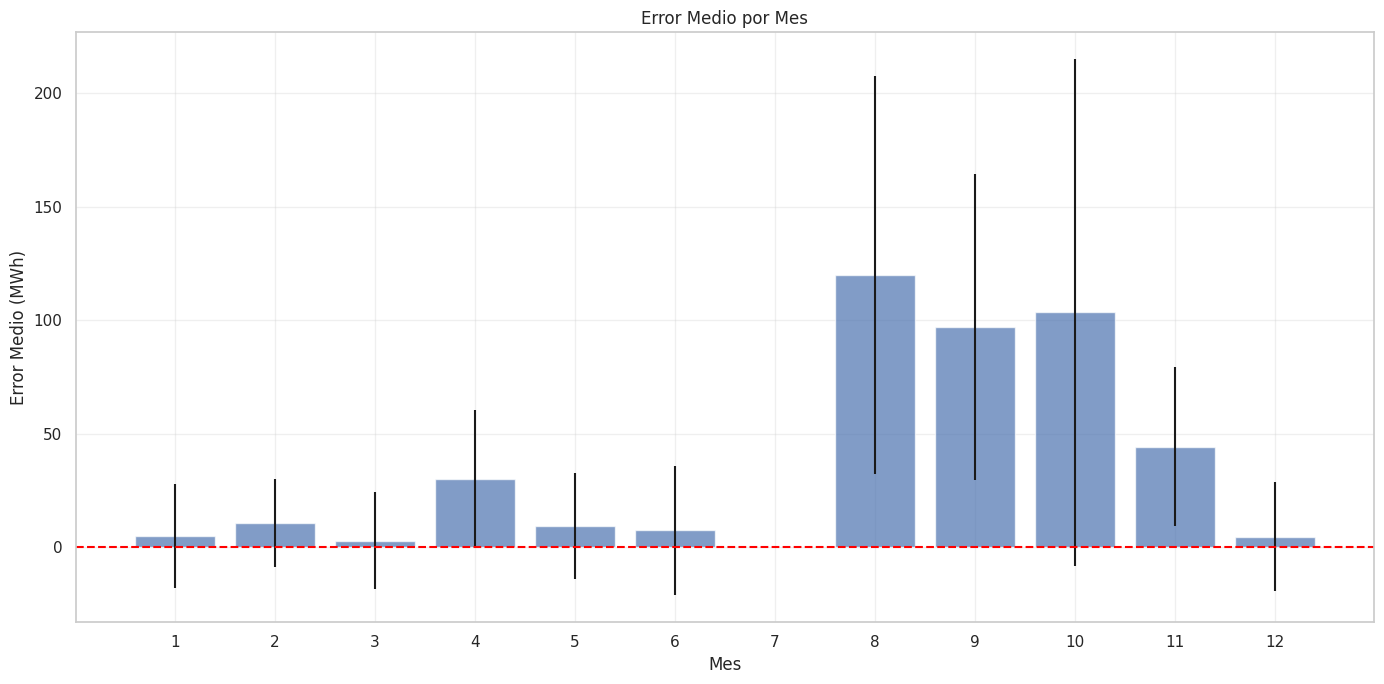

In [66]:
# Análisis de rendimiento por zonas
# Crear un DataFrame con predicciones y valores reales
test_indices = X_nn_test.index
test_dates = df.loc[test_indices, 'fecha']
test_targets = y_test_original
test_predictions = y_pred_MultiBranch_original

# Calcular el error
errors = test_targets - test_predictions
test_results = pd.DataFrame({
    'fecha': test_dates,
    'real': test_targets,
    'prediccion': test_predictions,
    'error': errors
})

# Unir con los datos originales para obtener información de zonas
test_results_with_zones = pd.merge(
    test_results,
    df[['fecha', 'temp_norte', 'temp_este', 'temp_sur', 'consumo_zona_norte', 'consumo_zona_este', 'consumo_zona_sur', 'consumo_zona_resto']],
    on='fecha'
)

# Analizar el error por temperatura
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Error vs Temperatura Norte
axes[0].scatter(test_results_with_zones['temp_norte'], test_results_with_zones['error'], alpha=0.5)
axes[0].set_title('Error vs Temperatura Norte')
axes[0].set_xlabel('Temperatura (°C)')
axes[0].set_ylabel('Error (MWh)')
axes[0].grid(True, alpha=0.3)

# Error vs Temperatura Este
axes[1].scatter(test_results_with_zones['temp_este'], test_results_with_zones['error'], alpha=0.5)
axes[1].set_title('Error vs Temperatura Este')
axes[1].set_xlabel('Temperatura (°C)')
axes[1].set_ylabel('Error (MWh)')
axes[1].grid(True, alpha=0.3)

# Error vs Temperatura Sur
axes[2].scatter(test_results_with_zones['temp_sur'], test_results_with_zones['error'], alpha=0.5)
axes[2].set_title('Error vs Temperatura Sur')
axes[2].set_xlabel('Temperatura (°C)')
axes[2].set_ylabel('Error (MWh)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calcular métricas por mes para analizar estacionalidad
test_results_with_zones['mes'] = pd.to_datetime(test_results_with_zones['fecha']).dt.month
monthly_metrics = test_results_with_zones.groupby('mes').agg({
    'error': ['mean', 'std'],
    'real': 'mean',
    'prediccion': 'mean'
}).reset_index()

# Visualizar métricas mensuales
plt.figure(figsize=(14, 7))
plt.bar(monthly_metrics['mes'], monthly_metrics['error']['mean'], yerr=monthly_metrics['error']['std'], alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Error Medio por Mes')
plt.xlabel('Mes')
plt.ylabel('Error Medio (MWh)')
plt.xticks(range(1, 13))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### **Comparación de modelos**

Comparamos los tres modelos implementados en términos de sus métricas de rendimiento.

In [67]:
# Crear un DataFrame con las métricas de los tres modelos
models_comparison = pd.DataFrame({
    'Modelo': [f'{best_linear_model_name}', 'Random Forest', 'Red Neuronal Multi-Branch'],
    'MAE': [mae_linear, mae_rf, mae_MultiBranch],
    'RMSE': [rmse_linear, rmse_rf, rmse_MultiBranch],
    'R²': [r2_linear, r2_rf, r2_MultiBranch]
})

# Mostrar la tabla de comparación
models_comparison

,Modelo,MAE,RMSE,R²
0,Linear Regression,372.803693,448.231821,0.317403
1,Random Forest,383.133276,450.792663,0.309581
2,Red Neuronal Multi-Branch,46.042094,76.298776,0.980221


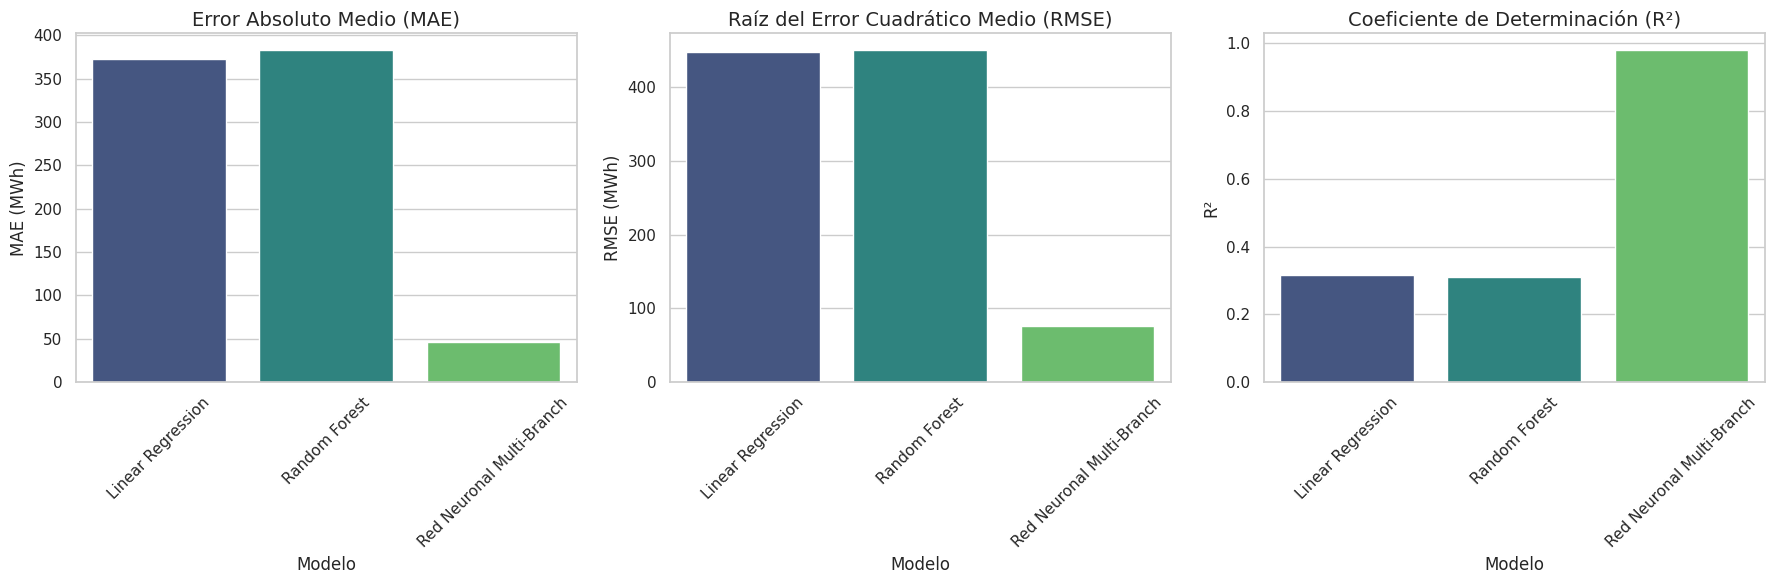

In [68]:
# Visualizar la comparación de métricas
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# MAE
sns.barplot(x='Modelo', y='MAE', data=models_comparison, ax=axes[0], palette='viridis')
axes[0].set_title('Error Absoluto Medio (MAE)', fontsize=14)
axes[0].set_ylabel('MAE (MWh)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# RMSE
sns.barplot(x='Modelo', y='RMSE', data=models_comparison, ax=axes[1], palette='viridis')
axes[1].set_title('Raíz del Error Cuadrático Medio (RMSE)', fontsize=14)
axes[1].set_ylabel('RMSE (MWh)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# R²
sns.barplot(x='Modelo', y='R²', data=models_comparison, ax=axes[2], palette='viridis')
axes[2].set_title('Coeficiente de Determinación (R²)', fontsize=14)
axes[2].set_ylabel('R²', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

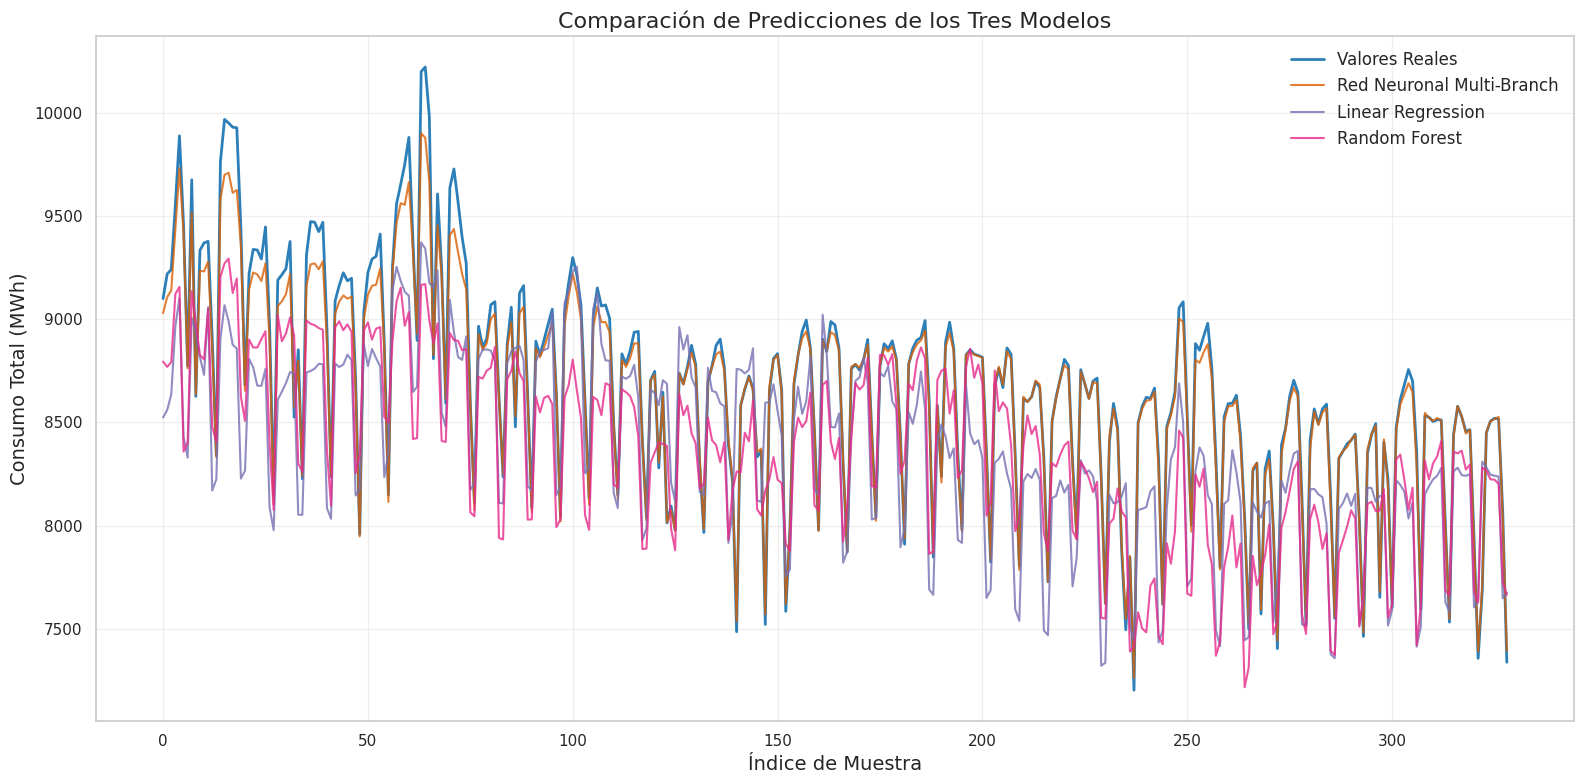

In [69]:
# Visualizar las predicciones de los tres modelos juntas
plt.figure(figsize=(16, 8))
plt.plot(y_test_original, label='Valores Reales', color='#2C7FB8', linewidth=2)
plt.plot(y_pred_MultiBranch_original, label='Red Neuronal Multi-Branch', color='#D95F02', linewidth=1.5, alpha=0.8)
plt.plot(y_pred_linear_original, label=f'{best_linear_model_name}', color='#7570B3', linewidth=1.5, alpha=0.8)
plt.plot(y_pred_rf_original, label='Random Forest', color='#E7298A', linewidth=1.5, alpha=0.8)
plt.title('Comparación de Predicciones de los Tres Modelos', fontsize=16)
plt.xlabel('Índice de Muestra', fontsize=14)
plt.ylabel('Consumo Total (MWh)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### **Guardamos el modelo**

In [70]:
# Guardar los escaladores para su uso posterior en la API
import joblib

# Crear un directorio para los modelos si no existe
import os
if not os.path.exists('models'):
    os.makedirs('models')

# Guardar los escaladores
joblib.dump(scaler_meteo_temp, 'models/scaler_meteo_temp.pkl')
joblib.dump(scaler_consumo, 'models/scaler_consumo.pkl')
joblib.dump(scaler_target, 'models/scaler_target.pkl')

print("Escaladores guardados correctamente.")

Escaladores guardados correctamente.


In [71]:
# Guardar el modelo entrenado
torch.save(model_MultiBranch.state_dict(), 'models/MultiBranch_nn_model.pth')
print("Modelo guardado correctamente.")

Modelo guardado correctamente.
